## Background

<figure>&nbsp;
<img src="img/schema.jpg" alt="Drawing" style="width: 600px;"/>&nbsp;
<figcaption align = "center"> Fig 1: Schematic illustrating real time control loop. IMU = Inertial Measurement Unit; FES = Functional Electrical Stimulation; 'control unit' = machine learning model </figcaption>
</figure> &nbsp;

The BioStim device incorporates motion sensors, an embedded machine learning model and electrodes into a wearable device, providing a platform for the modification of the muscle contractions of a patient in real time during rehabilitation. Motion data, sampled at 500Hz, form a continuous stream of input to the onboard ML model which generates, for every new sample, a scalar integer output corresponding to the current gait phase of the patient, _p_. _p_ is used to determine the onset and offset of neuromuscular stimulation.

<figure>&nbsp;
<img src="img/gc.png" alt="Drawing" style="width: 600px;"/>&nbsp;
<figcaption align = "center"> Fig 2: Gait cycle defined with reference to the right (red) limb</figcaption>
</figure>

The gait cycle is defined with reference to a given limb - left or right - and comprises stance phase (from the moment of heelstrike to the moment of toe-off) and swing phase (from toe-off to subsequent heelstrike); see Fig. 2. We further subdivide stance and swing into 6 phases, giving 12 phases in total so that the gait phase _p_ lies in the interval $(0, 11)$.  The phases are numbered consecutively from the start of stance to the end of swing. Phases 0-5 inclusive make up stance, with phase 0 representing the period immediately following heel-strike. Phases 6-11 make up swing, with phase 11 representing the period immediately preceding heelstrike. Your modelling task is to predict this scalar integer using the sensor data as input. That is, using _any_ of the sensor data available up to and including (but not beyond) time _t_, predict the gait phase at time _t_.  

### Data format
The dataset comprises 6 CSV files, taken from 5 subjects. Filenames are provided in the format 'ID_ACTIVITY.csv' where ID is a three digit subject identifier and ACTIVITY denotes the activity recorded; 'walk' = walking, 'jog' = jogging, 'var' = various. All recordings were taken at 500Hz. Note that a broad range of different walking and running speeds is represented. Each CSV represents a single contiguous recording with the arrow of time running from top to bottom. Each row represents the data sampled at a given timepoint - the interval between successive rows is 1000/500 = 2ms. 

#### Features 
Features are recorded from two motion sensors embedded in the device. Left and right are defined from the subject's point of view. Linear accelerations are given in $m/s^2$; angular velocities are in $degrees/s$.

- _acc_x_left_: x-component of linear acceleration from left sensor
- _acc_y_left_: y-component of linear acceleration from left sensor
- _acc_z_left_: z-component of linear acceleration from left sensor
- _gyr_x_left_: x-component of angular velocity from left sensor
- _gyr_y_left_: y-component of angular velocity from left sensor
- _gyr_z_left_: z-component of angular velocity from left sensor

- _acc_x_right_: x-component of linear acceleration from right sensor
- _acc_y_right_: y-component of linear acceleration from right sensor
- _acc_z_right_: z-component of linear acceleration from right sensor
- _gyr_x_right_: x-component of angular velocity from right sensor
- _gyr_y_right_: y-component of angular velocity from right sensor
- _gyr_z_right_: z-component of angular velocity from right sensor

#### Label
_left_phase_: Integer in the interval $(0, 11)$ corresponding to the gait phase of the left leg of the subject. Data for the right leg are not provided.


### Constraints
In the embedded environment, severe constraints exist on available compute and memory. For the purposes of this exercise, you may disregard these constraints.

### Additional background
Please see the attached _Addendum.pdf_ for additional information.

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# To remove these warnings : "Your kernel may have been built without NUMA support."
#   run these 2 lines before importing tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'        # or any {'0', '1', '2', '3'}

import tensorflow as tf 
random_state = 10
np.random.seed(random_state)
tf.random.set_seed(random_state)

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import make_column_transformer

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# print all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
import glob
filenames = glob.glob('data/*.csv')

## 1. Data exploration

In [3]:
# separate the files from filenames 
for file in filenames:
    print(file)

data\004_jog.csv
data\009_walk.csv
data\011_var.csv
data\014_var.csv
data\017_jog.csv
data\017_walk.csv


In [4]:
df_004_jog = pd.read_csv('data/004_jog.csv')
df_009_walk = pd.read_csv('data/009_walk.csv')
df_011_var = pd.read_csv('data/011_var.csv')
df_014_var = pd.read_csv('data/014_var.csv')
df_017_jog = pd.read_csv('data/017_jog.csv')
df_017_walk = pd.read_csv('data/017_walk.csv')

In [5]:
# function to add time column to the dataframes 
def add_time_column(df):
    df['time'] = df.index * 0.002
    return df

In [6]:
# add time column to each dataframe where the frequency is 500Hz (2ms) 
for df in [df_004_jog, df_009_walk, df_011_var, df_014_var, df_017_jog, df_017_walk]:
    df = add_time_column(df)

In [7]:
# create a function for performing exploratory data analysis (EDA) on each dataframe 
def perform_eda(df):
    print("Shape of dataframe:")
    print(df.shape)
    print("Describe dataframe:")
    print(df.describe())
    print("Null values:")
    print(df.isnull().sum())
    print("Dtypes of dataframe:")
    print(df.dtypes)
    print("Number of unique values of target:")
    print(df['left_phase'].nunique())

In [8]:
perform_eda(df_004_jog)

Shape of dataframe:
(100000, 15)
Describe dataframe:
          Unnamed: 0     acc_x_left     acc_y_left     acc_z_left  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    49999.500000      21.285479       4.548663      -4.090134   
std     28867.657797      22.790747      16.098607      12.163902   
min         0.000000     -19.305293     -78.408011     -78.408011   
25%     24999.750000       0.708275      -2.048256     -10.547562   
50%     49999.500000      17.185252       7.274181      -3.608376   
75%     74999.250000      39.117864      14.203795       1.741975   
max     99999.000000      78.398440      78.398440      78.398440   

          gyr_x_left     gyr_y_left     gyr_z_left    acc_x_right  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        5.273927       2.013574      -1.551948      21.540882   
std       129.715254      60.054926     153.651764      23.238003   
min     -1481.312500    -382.125000    -385.37500

In [9]:
perform_eda(df_009_walk)

Shape of dataframe:
(100000, 15)
Describe dataframe:
          Unnamed: 0     acc_x_left     acc_y_left     acc_z_left  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    49999.500000      19.464004       4.154484      -2.962999   
std     28867.657797       7.337527       8.416200       6.002489   
min         0.000000     -46.133620     -78.408011     -78.408011   
25%     24999.750000      14.778072       0.181855      -5.005785   
50%     49999.500000      17.448462       3.818945      -2.182254   
75%     74999.250000      20.932412       6.719046       0.076570   
max     99999.000000      77.211600      78.398440      67.066032   

          gyr_x_left     gyr_y_left     gyr_z_left    acc_x_right  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        1.248296      -3.034467       2.025865      20.467582   
std        82.859965      44.621771      95.873023       7.818037   
min      -967.187500    -265.875000    -524.93750

In [10]:
perform_eda(df_011_var)

Shape of dataframe:
(100000, 15)
Describe dataframe:
          Unnamed: 0     acc_x_left     acc_y_left     acc_z_left  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    49999.500000      19.136746       5.496977      -3.322816   
std     28867.657797      15.233837      11.178558       7.402669   
min         0.000000     -78.408011     -78.408011     -78.408011   
25%     24999.750000      10.327422      -1.464407      -7.427321   
50%     49999.500000      18.874585       5.675775      -3.933800   
75%     74999.250000      28.608587      11.983256       0.421137   
max     99999.000000      78.398440      78.398440      78.398440   

          gyr_x_left     gyr_y_left     gyr_z_left    acc_x_right  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        8.267956       1.207790       0.673717      20.024776   
std        85.569577      67.705617     128.761308      15.628065   
min     -1770.500000    -366.750000    -321.68750

In [11]:
perform_eda(df_014_var)

Shape of dataframe:
(74407, 15)
Describe dataframe:
         Unnamed: 0    acc_x_left    acc_y_left    acc_z_left    gyr_x_left  \
count  74407.000000  74407.000000  74407.000000  74407.000000  74407.000000   
mean   37203.000000      9.159306      2.825597     -2.375695      3.861133   
std    21479.595077      9.236200      7.217112      5.608894     95.218876   
min        0.000000    -27.641887    -54.891350    -55.063634   -805.375000   
25%    18601.500000      4.479364     -0.507278     -4.441079    -53.250000   
50%    37203.000000      8.432307      2.364109     -2.086541     13.062500   
75%    55804.500000     12.021541      6.049056      0.899701     68.562500   
max    74406.000000     46.363331     52.785667     36.437903    727.312500   

         gyr_y_left    gyr_z_left   acc_x_right   acc_y_right   acc_z_right  \
count  74407.000000  74407.000000  74407.000000  74407.000000  74407.000000   
mean      -2.633392     -0.016469      9.956212     -2.670858     -1.592990   

In [12]:
perform_eda(df_017_jog)

Shape of dataframe:
(19007, 15)
Describe dataframe:
         Unnamed: 0    acc_x_left    acc_y_left    acc_z_left    gyr_x_left  \
count  19007.000000  19007.000000  19007.000000  19007.000000  19007.000000   
mean    9503.000000     10.136004      3.099708     -1.533616      2.930920   
std     5486.992619     12.135106      9.070303      5.783061    164.724874   
min        0.000000    -10.968699    -40.256847    -43.759940   -405.687500   
25%     4751.500000      0.516850     -2.335395     -4.287938   -117.093750   
50%     9503.000000      8.863015      3.359523     -1.292124     -6.500000   
75%    14254.500000     17.295322      9.418150      1.966900    104.406250   
max    19006.000000     46.363331     51.378687     22.234108    676.687500   

         gyr_y_left    gyr_z_left   acc_x_right   acc_y_right   acc_z_right  \
count  19007.000000  19007.000000  19007.000000  19007.000000  19007.000000   
mean       0.387808      1.997570     10.599962     -3.561085     -1.763250   

In [13]:
perform_eda(df_017_walk)

Shape of dataframe:
(100000, 15)
Describe dataframe:
          Unnamed: 0     acc_x_left     acc_y_left     acc_z_left  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    49999.500000       9.632634       1.953064      -1.274454   
std     28867.657797       3.321915       4.035197       2.858244   
min         0.000000     -35.356347     -54.891350     -40.706698   
25%     24999.750000       7.685746      -0.172283      -2.545963   
50%     49999.500000       9.140582       1.952543      -1.282553   
75%     74999.250000      11.179267       3.483950      -0.095713   
max     99999.000000      46.363331      52.785667      34.427932   

          gyr_x_left     gyr_y_left     gyr_z_left    acc_x_right  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        6.256439      -5.036424       1.395470       9.868508   
std        85.170280      53.622446      93.799570       3.423398   
min     -1238.375000    -468.000000    -353.68750

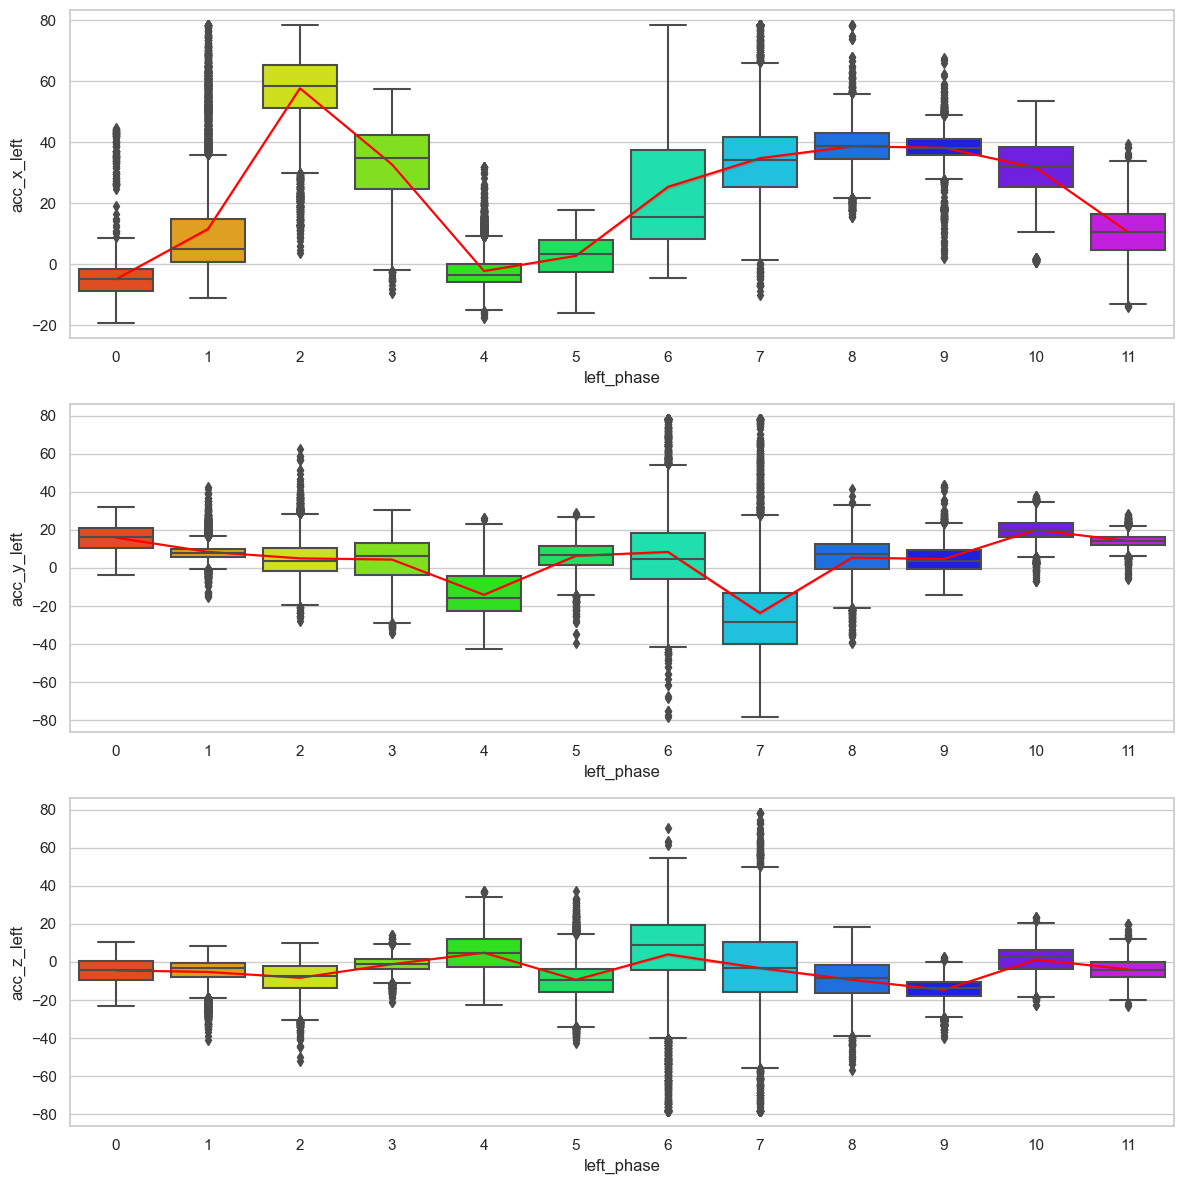

In [14]:
# boxplot acc_x_left wrt left_phase, acc_y_left wrt left_phase, acc_z_left wrt left_phase of df_004_jog 
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(data=df_004_jog, x="left_phase", y="acc_x_left", ax=axs[0], palette="gist_rainbow")
sns.lineplot(data=df_004_jog, x="left_phase", y="acc_x_left", ax=axs[0], color="red")
sns.boxplot(data=df_004_jog, x="left_phase", y="acc_y_left", ax=axs[1], palette="gist_rainbow")
sns.lineplot(data=df_004_jog, x="left_phase", y="acc_y_left", ax=axs[1], color="red")
sns.boxplot(data=df_004_jog, x="left_phase", y="acc_z_left", ax=axs[2], palette="gist_rainbow")
sns.lineplot(data=df_004_jog, x="left_phase", y="acc_z_left", ax=axs[2], color="red")
plt.tight_layout()
plt.show()

* The median acceleration acc_x_left of person while jogging in stance phase is higher than in swing phase, this is because the person is pushing off the ground with their foot while jogging in stance phase.
* This means that the person is moving faster in stance phase than in swing phase. 
* The median acceleration acc_y_left first goes down and then goes up in stance phase, this is because the person is pushing off the ground with their foot while jogging in stance phase.
* The median acceleration of acc_y_left goues down in swing phase and then goes up in stance phase, this is because the person is pushing off the ground with their foot while jogging in stance phase.
* The median acceleration acc_y_left of person while jogging in stance phase is lower than in swing phase, this is because the person is pushing off the ground with their foot while jogging in stance phase.
* The median acceleration acc_z_left of person while jogging in stance phase is higher than in swing phase, this is because the person is pushing off the ground with their foot while jogging in stance phase.

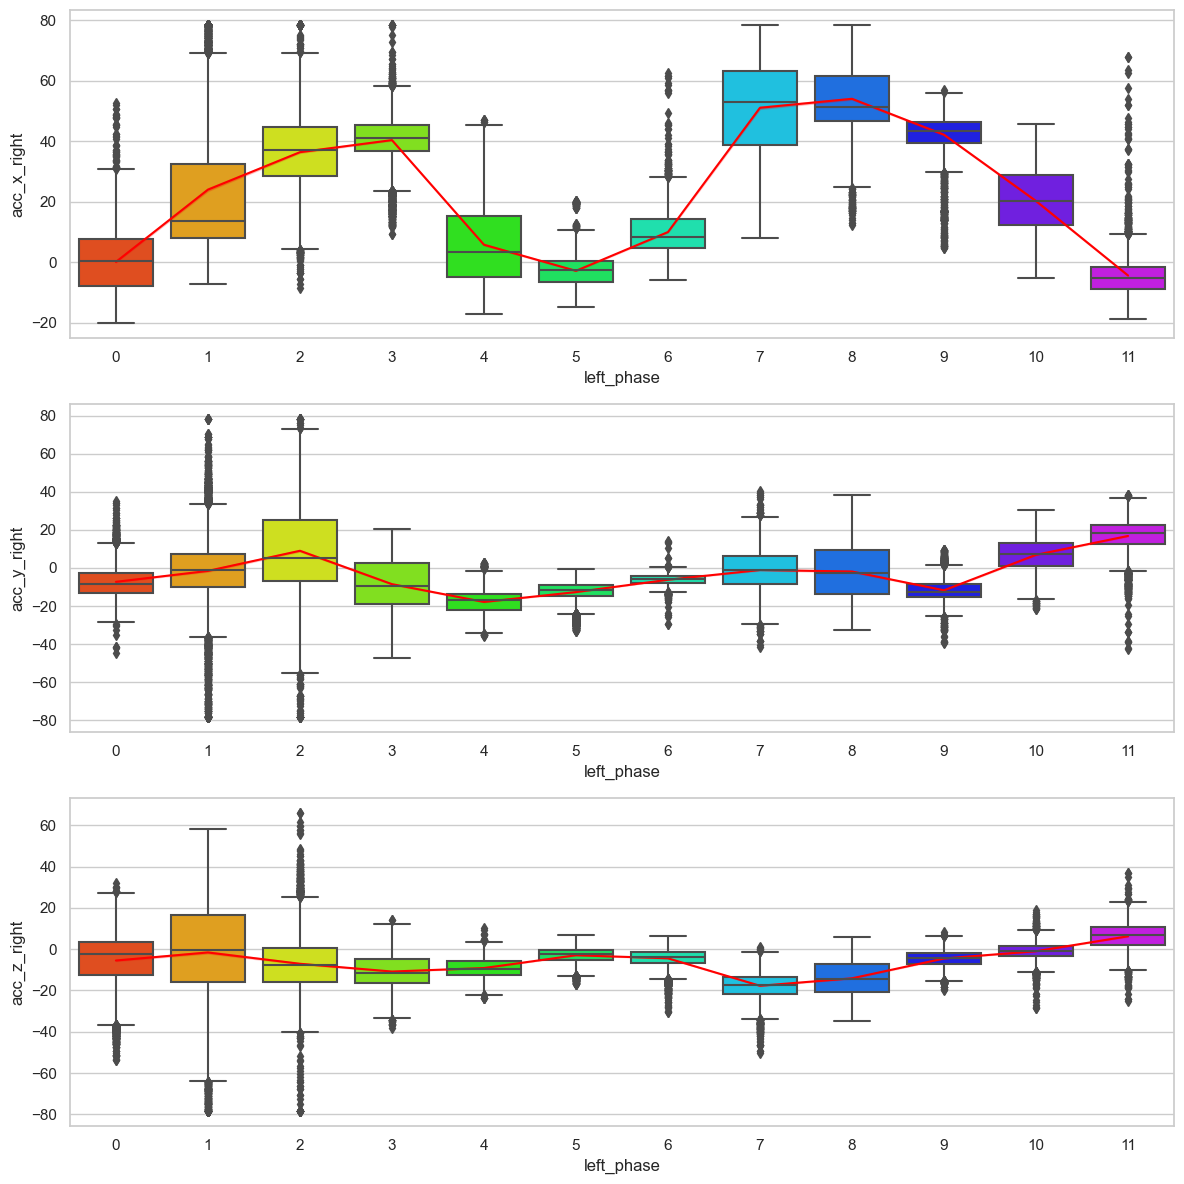

In [15]:
# boxplot of acc_x_right wrt left_phase, acc_y_right wrt left_phase, acc_z_right wrt left_phase of df_004_jog on top of each other
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(data=df_004_jog, x="left_phase", y="acc_x_right", ax=axs[0], palette="gist_rainbow")
sns.lineplot(data=df_004_jog, x="left_phase", y="acc_x_right", ax=axs[0], color="red")
sns.boxplot(data=df_004_jog, x="left_phase", y="acc_y_right", ax=axs[1], palette="gist_rainbow")
sns.lineplot(data=df_004_jog, x="left_phase", y="acc_y_right", ax=axs[1], color="red")
sns.boxplot(data=df_004_jog, x="left_phase", y="acc_z_right", ax=axs[2], palette="gist_rainbow")
sns.lineplot(data=df_004_jog, x="left_phase", y="acc_z_right", ax=axs[2], color="red")
plt.tight_layout()
plt.show()

* The acceleration acc_x_left of person while jogging in stance phase is higher than in swing phase, this is because the person is pushing off the ground with their foot while jogging in stance phase.
* This means that the person is moving faster in stance phase than in swing phase. 
* The acceleration acc_y_left of person while jogging in stance phase is lower than in swing phase, this is because the person is pushing off the ground with their foot while jogging in stance phase.
* This means that the person is moving faster in stance phase than in swing phase.
* The acceleration acc_z_left of person while jogging in stance phase is higher than in swing phase, this is because the person is pushing off the ground with their foot while jogging in stance phase.
* This means that the person is moving faster in stance phase than in swing phase.

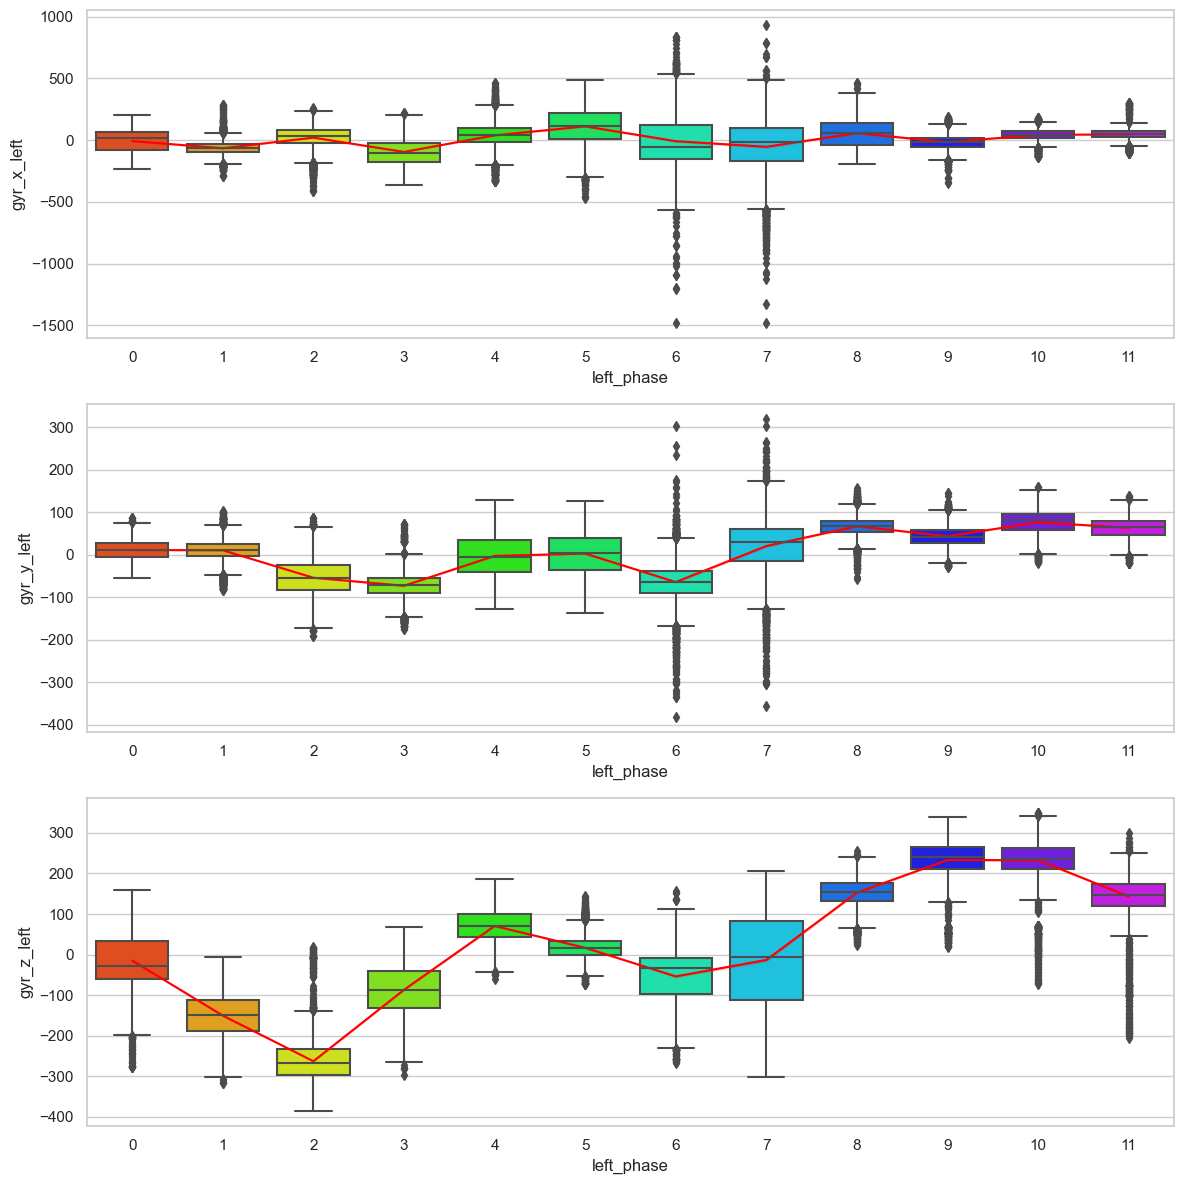

In [16]:
# boxplot of gyr_x_left wrt left_phase, gyr_y_left wrt left_phase, gyr_z_left wrt left_phase of df_004_jog
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(data=df_004_jog, x="left_phase", y="gyr_x_left", ax=axs[0], palette="gist_rainbow")
# draw a line plot joining the median values of gyr_x_left wrt left_phase
sns.lineplot(data=df_004_jog, x="left_phase", y="gyr_x_left", ax=axs[0], color='red')
sns.boxplot(data=df_004_jog, x="left_phase", y="gyr_y_left", ax=axs[1], palette="gist_rainbow")
sns.lineplot(data=df_004_jog, x="left_phase", y="gyr_y_left", ax=axs[1], color='red')
sns.boxplot(data=df_004_jog, x="left_phase", y="gyr_z_left", ax=axs[2], palette="gist_rainbow")
sns.lineplot(data=df_004_jog, x="left_phase", y="gyr_z_left", ax=axs[2], color='red')
plt.tight_layout()
plt.show()

* The median values of gyr_x_left is about 0 for all left_phase values, which means that person is not moving in the x direction (left or right)
* The median values of gyr_y_left first deacreases and then increased in stance phase and swing phase respectively
* This means that the person is moving in the y direction (up or down) in stance phase and swing phase respectively 
* The median values of gyr_z_left first dips and then increases in stance phase and swing phase respectively. The dip in stance phase is more than the increase in swing phase
* This means that the person is moving in the z direction (forward or backward) in stance phase and swing phase respectively. The dip in stance phase is more than the increase in swing phase

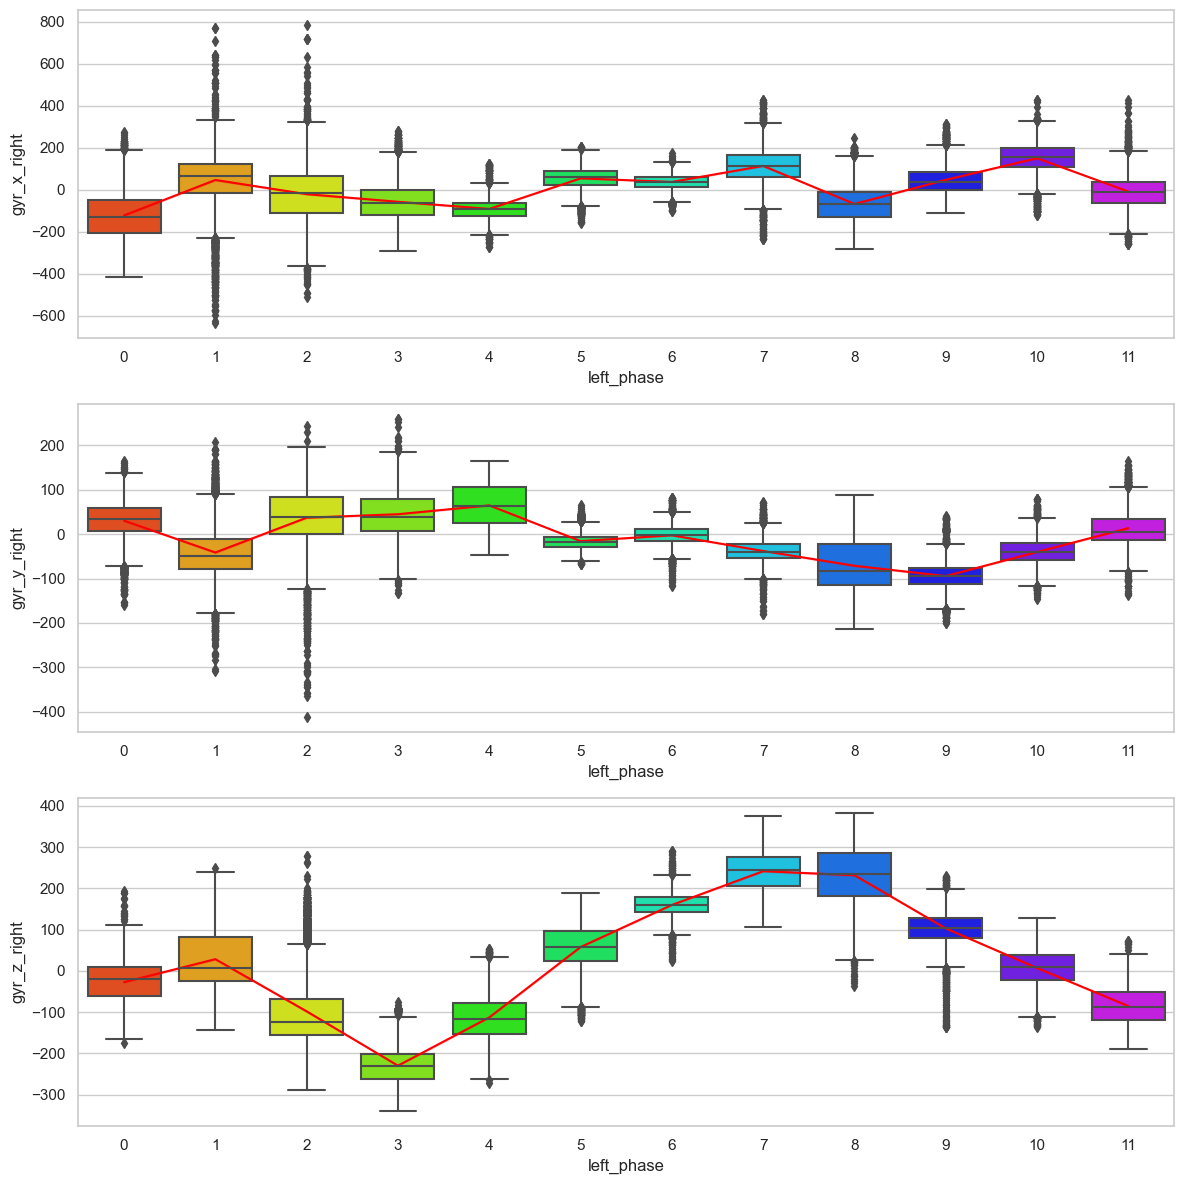

In [17]:
# boxplot of gyr_x_right wrt left_phase, gyr_y_right wrt left_phase, gyr_z_right wrt left_phase of df_004_jog 
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(data=df_004_jog, x="left_phase", y="gyr_x_right", ax=axs[0], palette="gist_rainbow")
sns.lineplot(data=df_004_jog, x="left_phase", y="gyr_x_right", ax=axs[0], color='red')
sns.boxplot(data=df_004_jog, x="left_phase", y="gyr_y_right", ax=axs[1], palette="gist_rainbow")
sns.lineplot(data=df_004_jog, x="left_phase", y="gyr_y_right", ax=axs[1], color='red')
sns.boxplot(data=df_004_jog, x="left_phase", y="gyr_z_right", ax=axs[2], palette="gist_rainbow")
sns.lineplot(data=df_004_jog, x="left_phase", y="gyr_z_right", ax=axs[2], color='red')
plt.tight_layout()
plt.show()

* The gyr_x_right has slight dip in stance phase and then rises again in stance phase.
* This might be due to the fact that the person is jogging on a slope.
* The gyr_x_right dips twice in swing phase and then rises again in swing phase.
* This might be due to the fact that the person is jogging on a slope. 

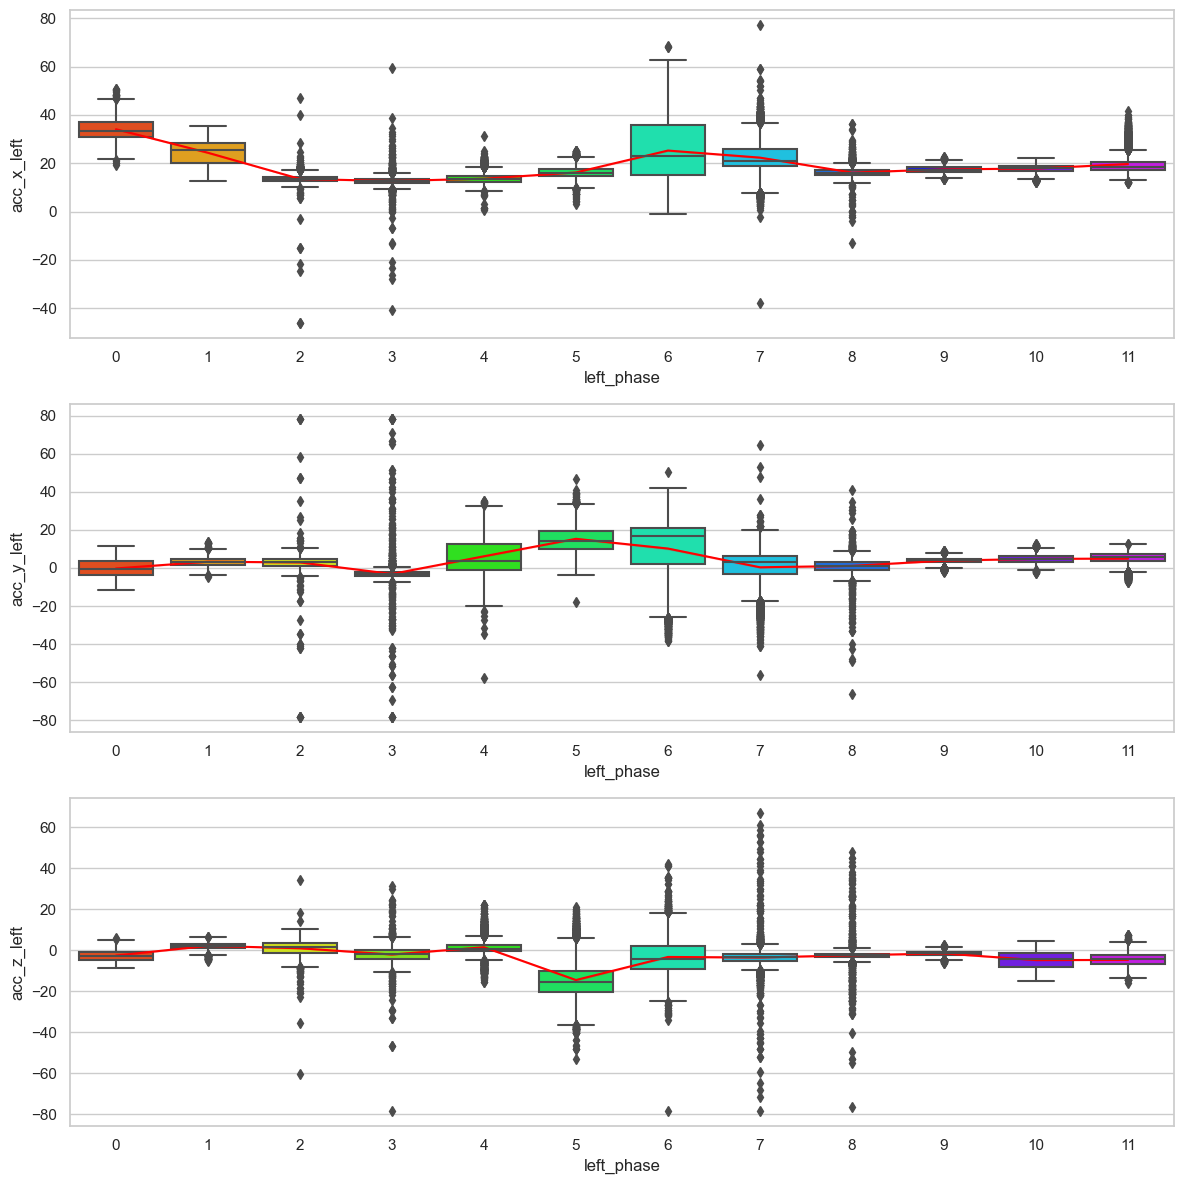

In [18]:
# boxplot of acc_x_left wrt left_phase, acc_y_left wrt left_phase, acc_z_left wrt left_phase of df_009_walk
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(data=df_009_walk, x="left_phase", y="acc_x_left", ax=axs[0], palette="gist_rainbow")
sns.lineplot(data=df_009_walk, x="left_phase", y="acc_x_left", ax=axs[0], color="red")
sns.boxplot(data=df_009_walk, x="left_phase", y="acc_y_left", ax=axs[1], palette="gist_rainbow")
sns.lineplot(data=df_009_walk, x="left_phase", y="acc_y_left", ax=axs[1], color="red")
sns.boxplot(data=df_009_walk, x="left_phase", y="acc_z_left", ax=axs[2], palette="gist_rainbow")
sns.lineplot(data=df_009_walk, x="left_phase", y="acc_z_left", ax=axs[2], color="red")
plt.tight_layout()

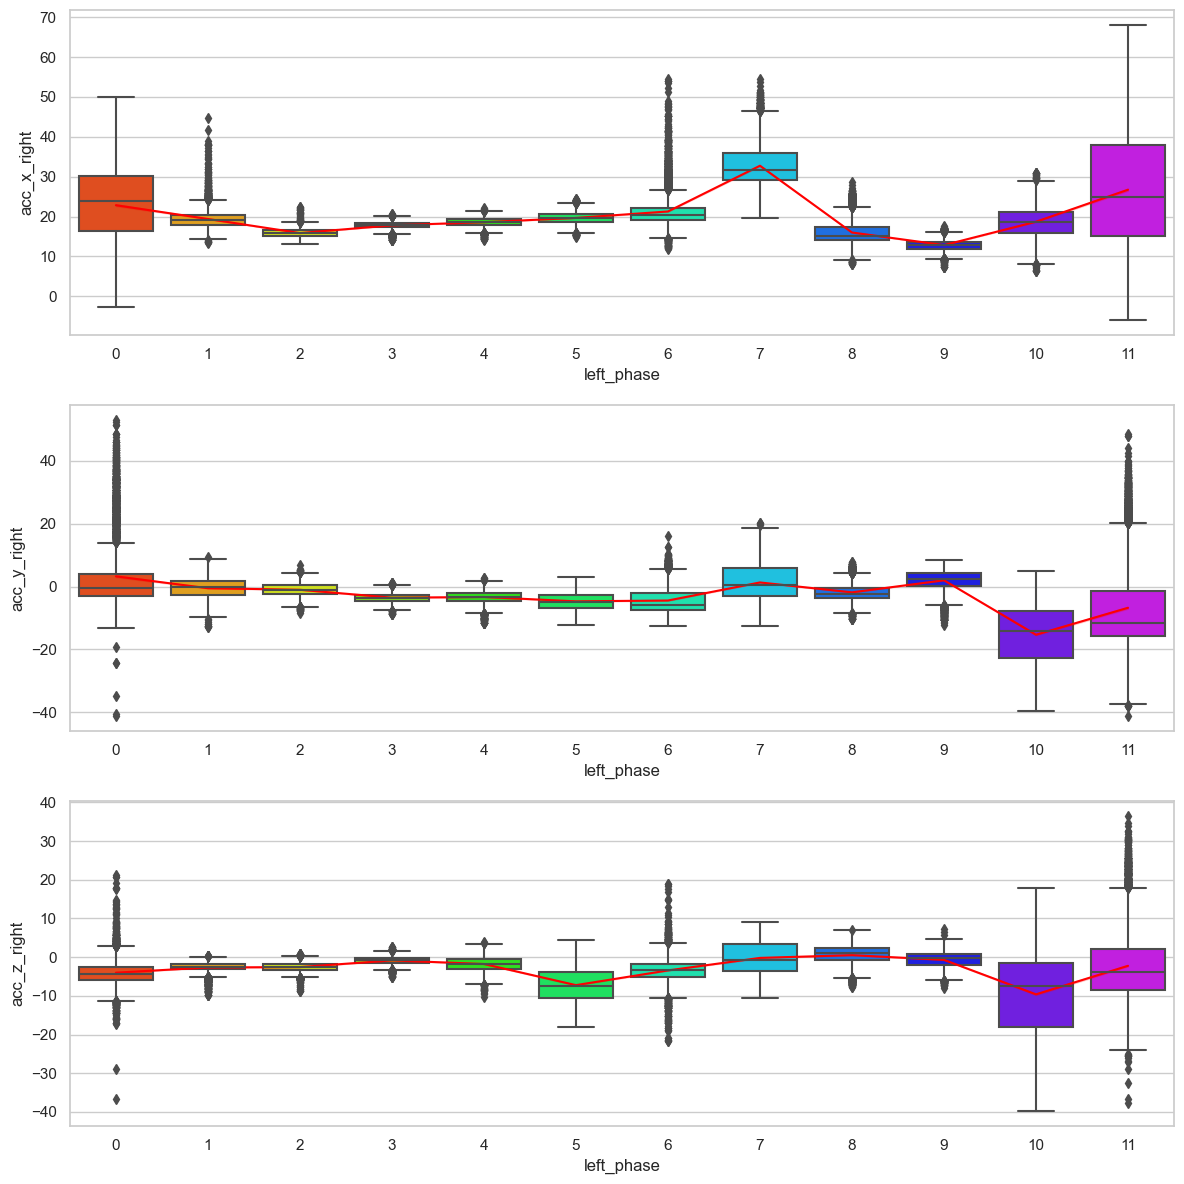

In [19]:
# boxplot of acc_x_right wrt left_phase, acc_y_right wrt left_phase, acc_z_right wrt left_phase of df_009_walk on top of each other
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(data=df_009_walk, x="left_phase", y="acc_x_right", ax=axs[0], palette="gist_rainbow")
sns.lineplot(data=df_009_walk, x="left_phase", y="acc_x_right", ax=axs[0], color="red")
sns.boxplot(data=df_009_walk, x="left_phase", y="acc_y_right", ax=axs[1], palette="gist_rainbow")
sns.lineplot(data=df_009_walk, x="left_phase", y="acc_y_right", ax=axs[1], color="red")
sns.boxplot(data=df_009_walk, x="left_phase", y="acc_z_right", ax=axs[2], palette="gist_rainbow")
sns.lineplot(data=df_009_walk, x="left_phase", y="acc_z_right", ax=axs[2], color="red")
plt.tight_layout()

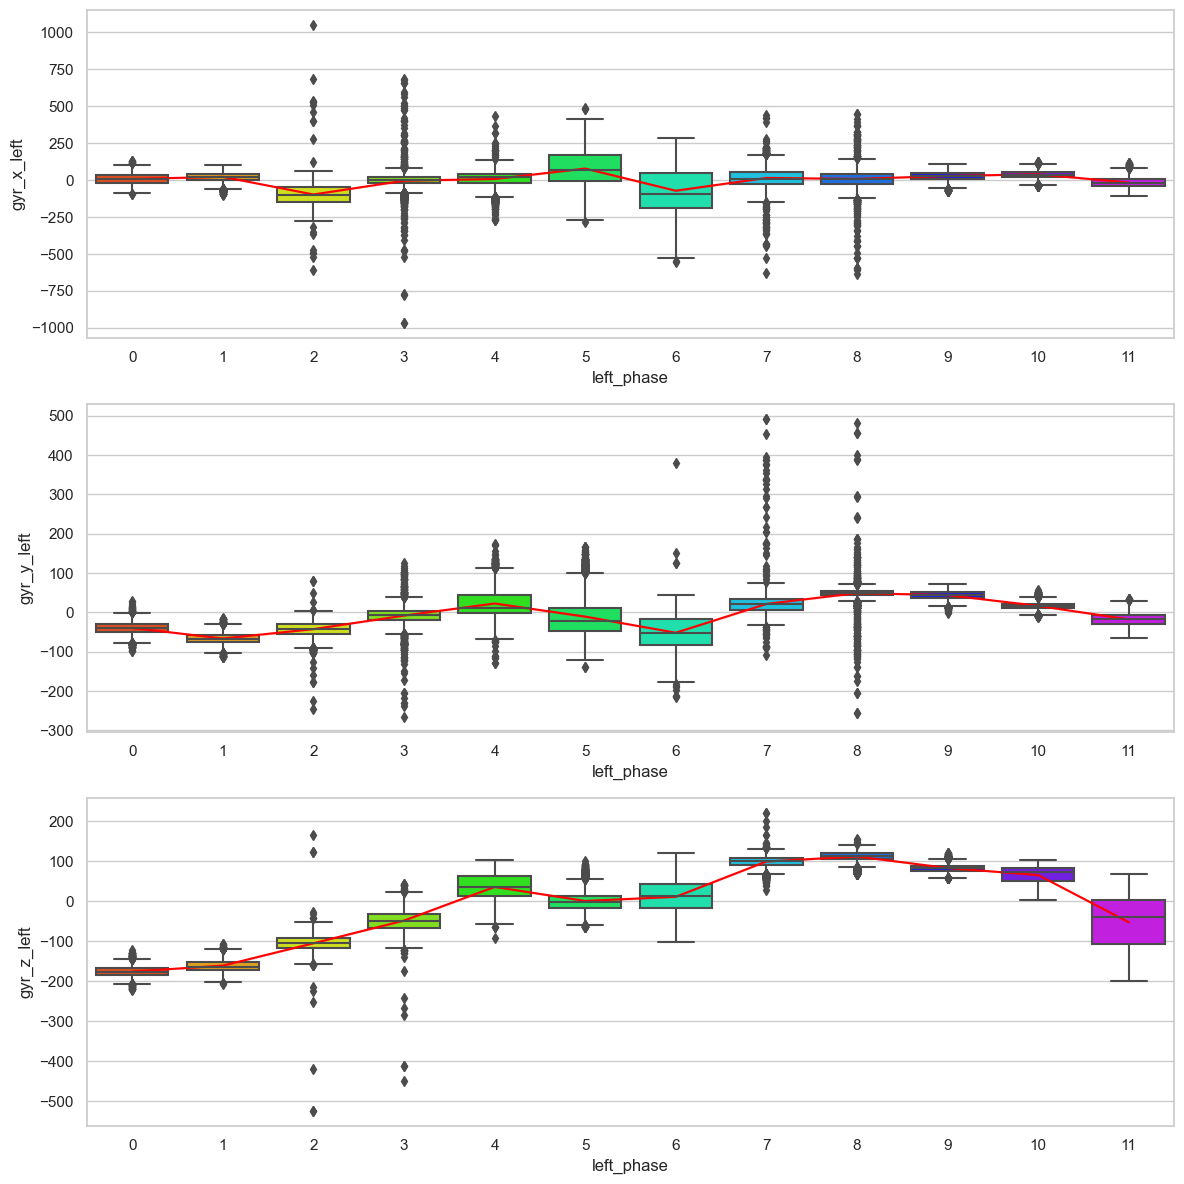

In [20]:
# boxplot of gyr_x_left wrt left_phase, gyr_y_left wrt left_phase, gyr_z_left wrt left_phase of df_009_walk on top of each other
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(data=df_009_walk, x="left_phase", y="gyr_x_left", ax=axs[0], palette="gist_rainbow")
sns.lineplot(data=df_009_walk, x="left_phase", y="gyr_x_left", ax=axs[0], color='red')
sns.boxplot(data=df_009_walk, x="left_phase", y="gyr_y_left", ax=axs[1], palette="gist_rainbow")
sns.lineplot(data=df_009_walk, x="left_phase", y="gyr_y_left", ax=axs[1], color='red')
sns.boxplot(data=df_009_walk, x="left_phase", y="gyr_z_left", ax=axs[2], palette="gist_rainbow")
sns.lineplot(data=df_009_walk, x="left_phase", y="gyr_z_left", ax=axs[2], color='red')
plt.tight_layout()

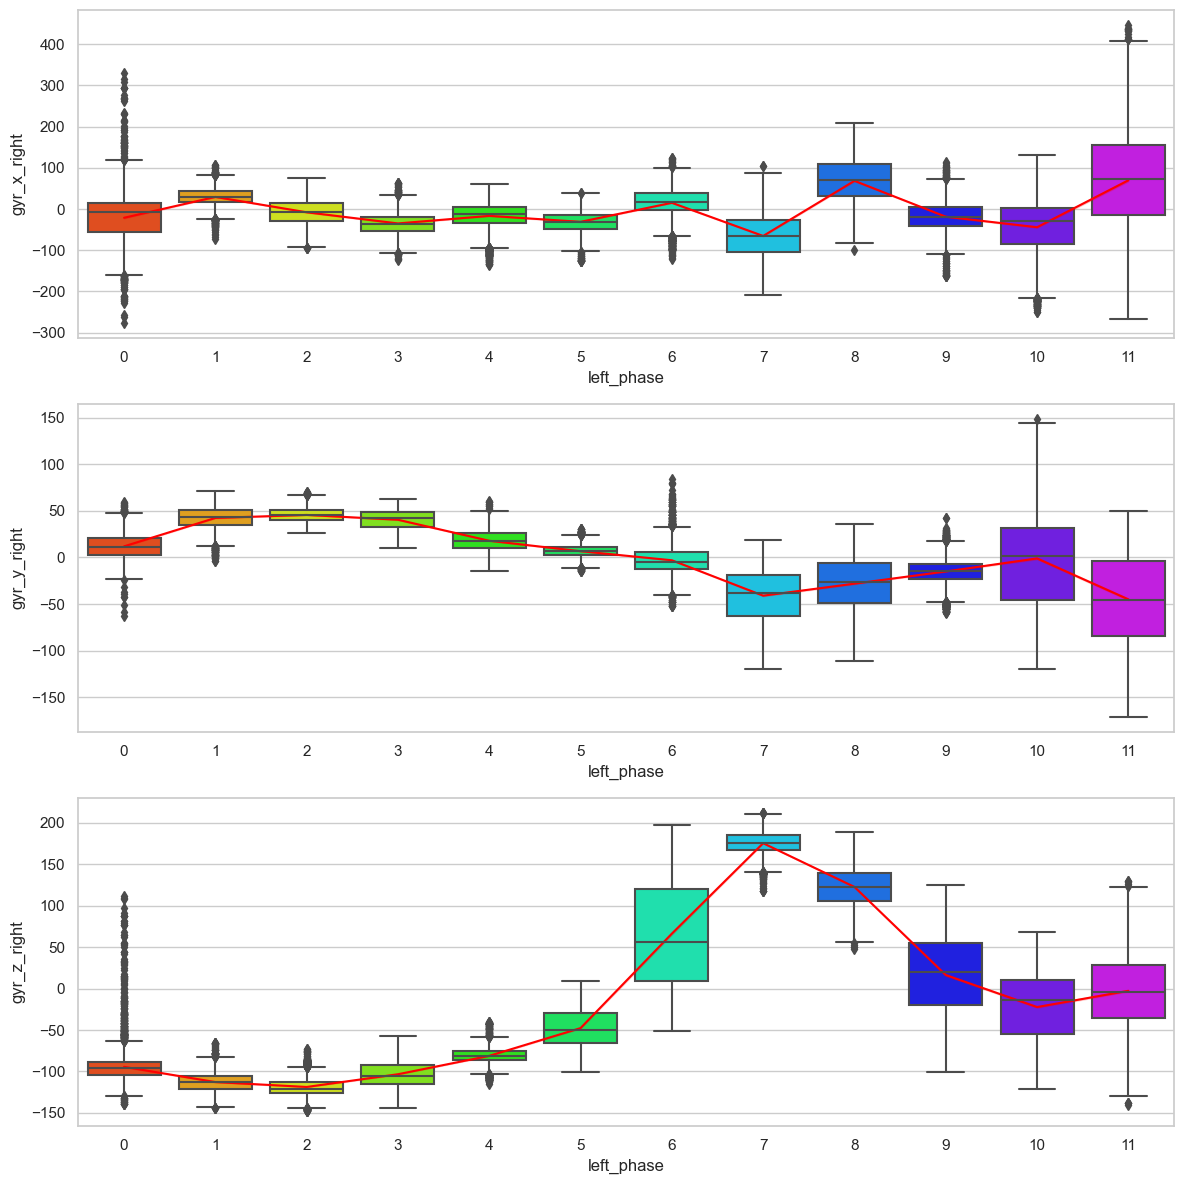

In [21]:
# boxplot of gyr_x_right wrt left_phase, gyr_y_right wrt left_phase, gyr_z_right wrt left_phase of df_009_walk on top of each other
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(data=df_009_walk, x="left_phase", y="gyr_x_right", ax=axs[0], palette="gist_rainbow")
sns.lineplot(data=df_009_walk, x="left_phase", y="gyr_x_right", ax=axs[0], color='red')
sns.boxplot(data=df_009_walk, x="left_phase", y="gyr_y_right", ax=axs[1], palette="gist_rainbow")
sns.lineplot(data=df_009_walk, x="left_phase", y="gyr_y_right", ax=axs[1], color='red')
sns.boxplot(data=df_009_walk, x="left_phase", y="gyr_z_right", ax=axs[2], palette="gist_rainbow")
sns.lineplot(data=df_009_walk, x="left_phase", y="gyr_z_right", ax=axs[2], color='red')
plt.tight_layout()

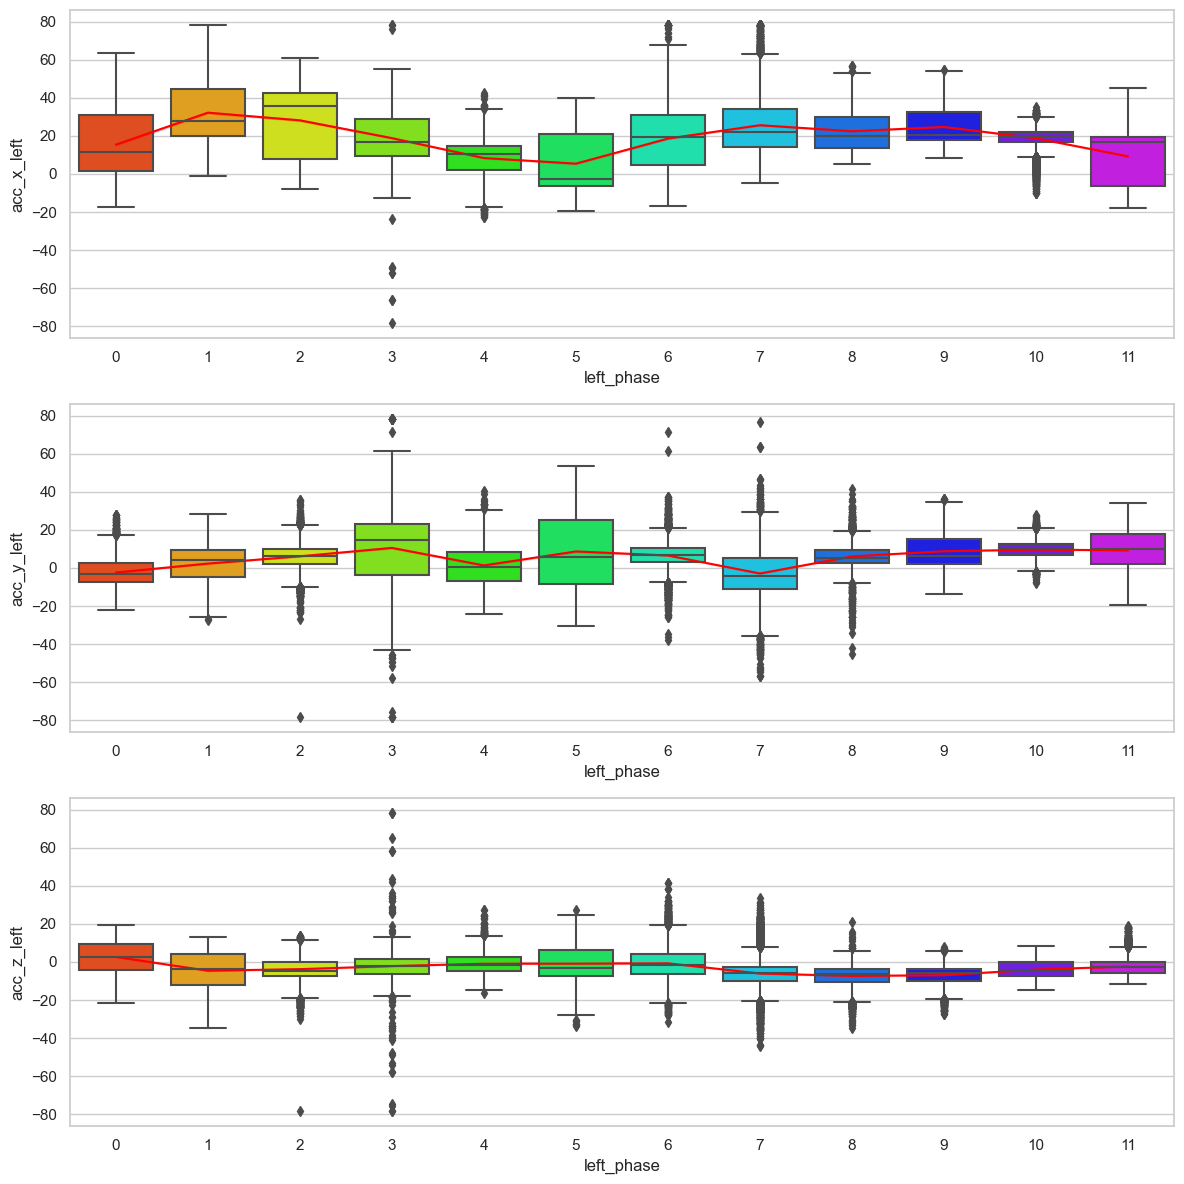

In [22]:
# boxplot of acc_x_left wrt left_phase, acc_y_left wrt left_phase, acc_z_left wrt left_phase of df_011_var on top of each other
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(data=df_011_var, x="left_phase", y="acc_x_left", ax=axs[0], palette="gist_rainbow")
sns.lineplot(data=df_011_var, x="left_phase", y="acc_x_left", ax=axs[0], color="red")
sns.boxplot(data=df_011_var, x="left_phase", y="acc_y_left", ax=axs[1], palette="gist_rainbow")
sns.lineplot(data=df_011_var, x="left_phase", y="acc_y_left", ax=axs[1], color="red")
sns.boxplot(data=df_011_var, x="left_phase", y="acc_z_left", ax=axs[2], palette="gist_rainbow")
sns.lineplot(data=df_011_var, x="left_phase", y="acc_z_left", ax=axs[2], color="red")
plt.tight_layout()

* The median value of acc_x_left initially increases and then decreases in stance phase and then increases, stays constant and then decreases in swing phase
* This means that the left foot is initially moving forward and then moving backward in stance phase and then moving forward, staying constant and then moving backward in swing phase
* The median value of acc_y_left in almost constant in stance phase and swing phase 
* This means that the left foot is not moving up or down in stance phase and swing phase
* The median value of acc_z_left almost consntant in stance phase and swing phase 
* This means that the left foot is not moving left or right in stance phase and swing phase

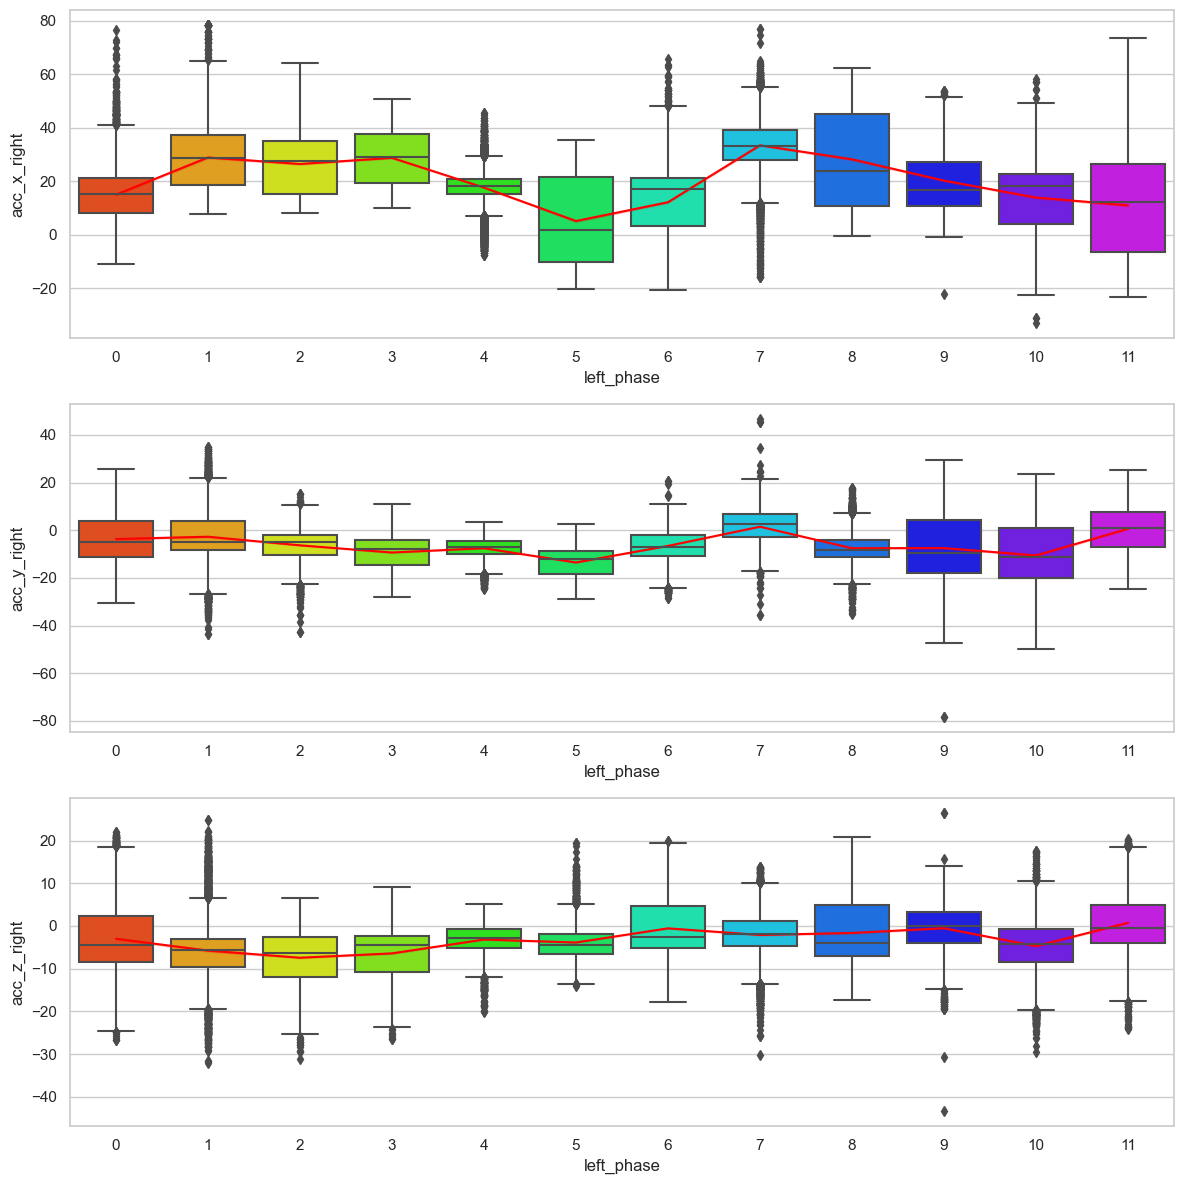

In [23]:
# boxplot of acc_x_right wrt left_phase, acc_y_right wrt left_phase, acc_z_right wrt left_phase of df_011_var on top of each other
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(data=df_011_var, x="left_phase", y="acc_x_right", ax=axs[0], palette="gist_rainbow")
sns.lineplot(data=df_011_var, x="left_phase", y="acc_x_right", ax=axs[0], color="red")
sns.boxplot(data=df_011_var, x="left_phase", y="acc_y_right", ax=axs[1], palette="gist_rainbow")
sns.lineplot(data=df_011_var, x="left_phase", y="acc_y_right", ax=axs[1], color="red")
sns.boxplot(data=df_011_var, x="left_phase", y="acc_z_right", ax=axs[2], palette="gist_rainbow")
sns.lineplot(data=df_011_var, x="left_phase", y="acc_z_right", ax=axs[2], color="red")
plt.tight_layout()

* The median values of acc_x_right initially increases, stays constant and then decreases in the stance phase
* This is because the right foot is initially behind the left foot, then the right foot is beside the left foot and then the right foot is in front of the left foot
* The median values of acc_x_right increases and then decreases in the swing phase
* This is because the right foot is initially in front of the left foot and then the right foot is behind the left foot
* The median value acc_y_right very slowly decreases in the stance phase
* This is because the right foot is initially behind the left foot, then the right foot is beside the left foot and then the right foot is in front of the left foot
* The median values of acc_y_right first increases then decreases and lastly increases in the swing phase
* This is because the right foot is initially in front of the left foot, then the right foot is behind the left foot and then the right foot is in front of the left foot
* The median values of acc_z_right almost stays constant in the stance phase and swing phase
* This is because the right foot is always on the ground in the stance phase and the right foot is always off the ground in the swing phase

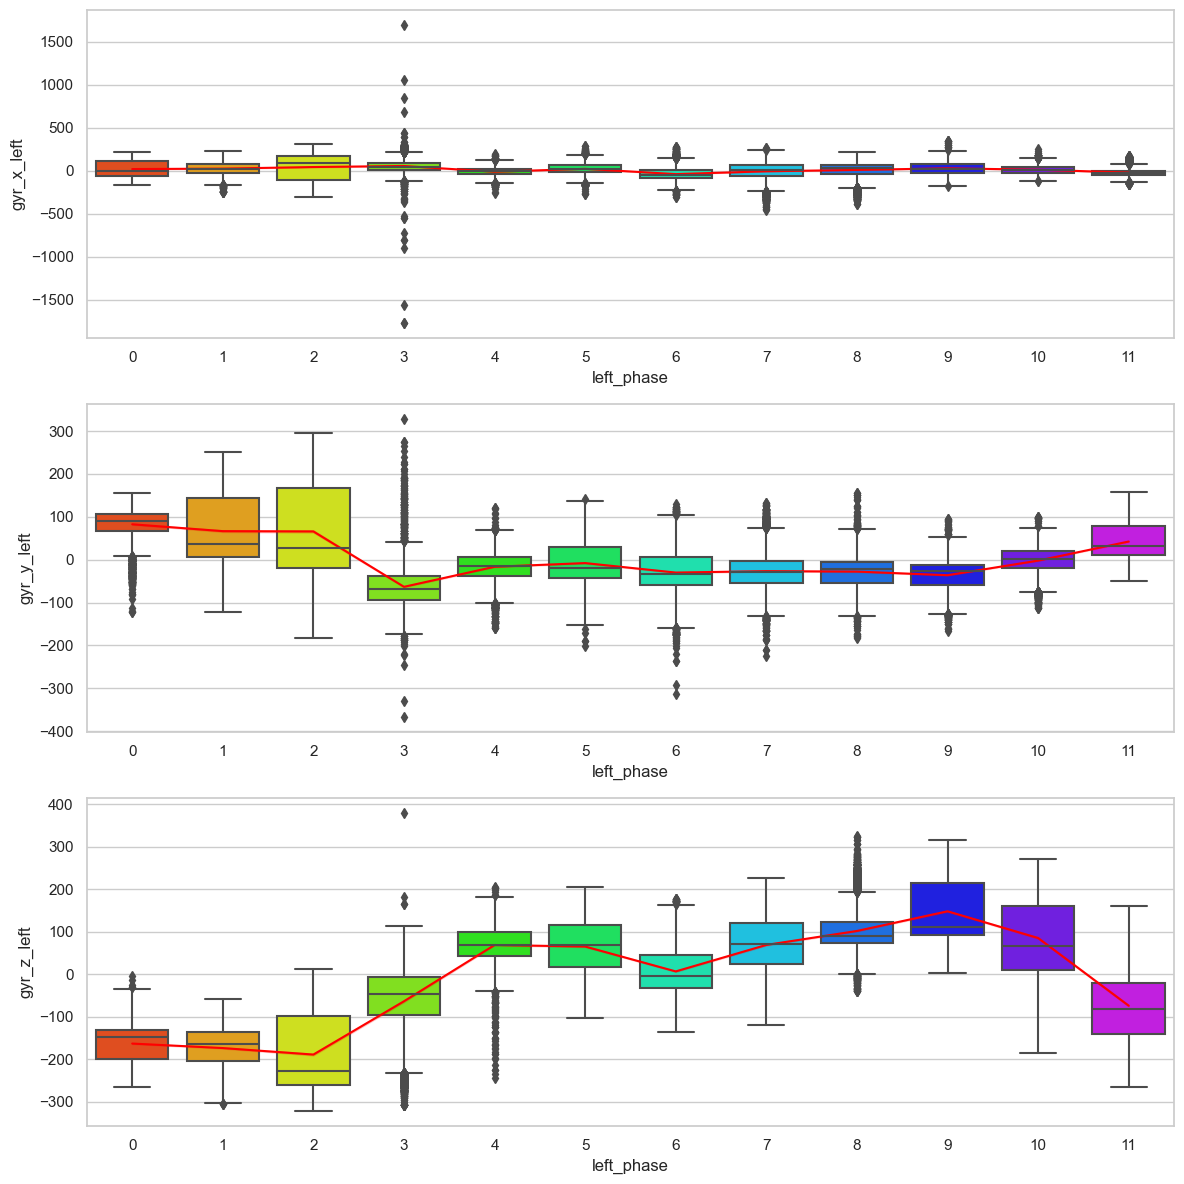

In [24]:
# boxplot of gyr_x_left wrt left_phase, gyr_y_left wrt left_phase, gyr_z_left wrt left_phase of df_011_var
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(data=df_011_var, x="left_phase", y="gyr_x_left", ax=axs[0], palette="gist_rainbow")
sns.lineplot(data=df_011_var, x="left_phase", y="gyr_x_left", ax=axs[0], color='red')
sns.boxplot(data=df_011_var, x="left_phase", y="gyr_y_left", ax=axs[1], palette="gist_rainbow")
sns.lineplot(data=df_011_var, x="left_phase", y="gyr_y_left", ax=axs[1], color='red')
sns.boxplot(data=df_011_var, x="left_phase", y="gyr_z_left", ax=axs[2], palette="gist_rainbow")
sns.lineplot(data=df_011_var, x="left_phase", y="gyr_z_left", ax=axs[2], color='red')
plt.tight_layout()

* The median value of gyr_x_left almost remains constant for all the left_phase values around 0, which means that the person is not moving much in the x direction
* The median value of gyr_y_left decreases in stance phase and increases in swing phase which means that the person is moving in the y direction
* The median value of gyr_z_left increases in stance phase and decreases in swing phase which means that the person is moving in the z direction

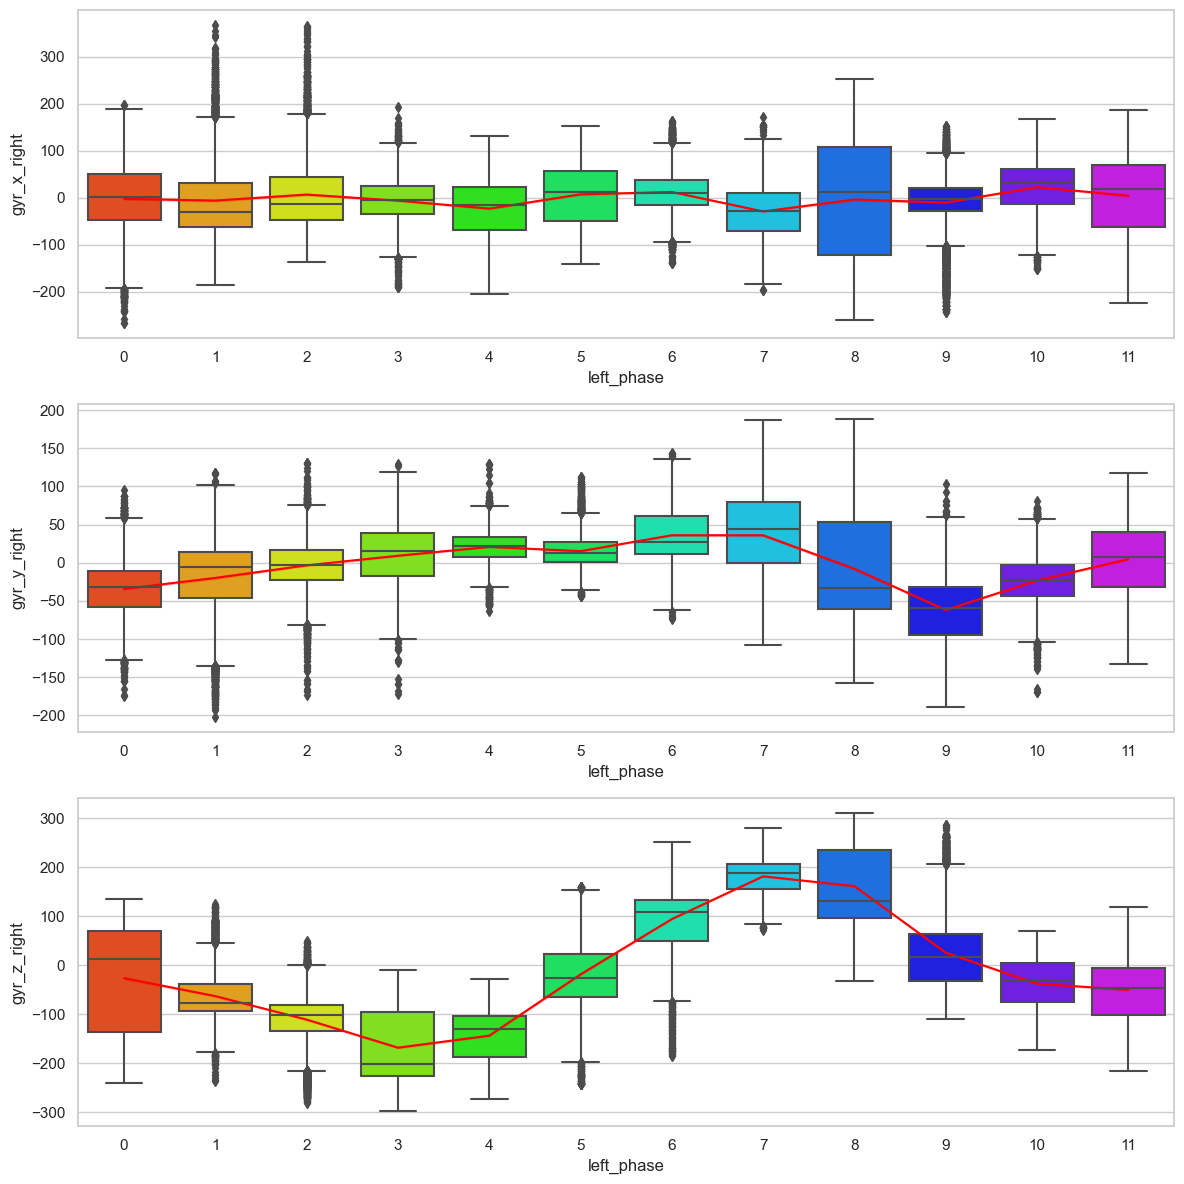

In [25]:
# boxplot of gyr_x_right wrt left_phase, gyr_y_right wrt left_phase, gyr_z_right wrt left_phase of df_011_var
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(data=df_011_var, x="left_phase", y="gyr_x_right", ax=axs[0], palette="gist_rainbow")
sns.lineplot(data=df_011_var, x="left_phase", y="gyr_x_right", ax=axs[0], color='red')
sns.boxplot(data=df_011_var, x="left_phase", y="gyr_y_right", ax=axs[1], palette="gist_rainbow")
sns.lineplot(data=df_011_var, x="left_phase", y="gyr_y_right", ax=axs[1], color='red')
sns.boxplot(data=df_011_var, x="left_phase", y="gyr_z_right", ax=axs[2], palette="gist_rainbow")
sns.lineplot(data=df_011_var, x="left_phase", y="gyr_z_right", ax=axs[2], color='red')
plt.tight_layout()

* The median values of gyr_x_right wrt left_phase is almost constant for all left_phase values, which means the person is not moving much in the x direction
* The median values of gyr_y_right keeps increasing from stance to swing phase, and then starts decreasing from swing to stance phase
* This means the person is moving in the y direction, and the movement is maximum in the swing phase
* The median values of gyr_z_right decreased from 0 into stance phase, and then increased from stance to swing phase, thereafter decreased from swing to stance phase
* This means the person is moving in the z direction, and the movement is maximum in the swing phase

In [26]:
# define the funtion to do everything above for different heights
from scipy.signal import find_peaks, peak_prominences
def plot_acc_vs_time_peaks(df, height1, height2, height3):
    fig, axes = plt.subplots(3, 1, figsize=(15,10))
    fig.suptitle('Acceleration vs Time')
    fig.tight_layout(pad=3.0)
    # set limits on x-axis 
    axes[0].set_xlim(21, 41.5)
    axes[0].plot(df['time'], df['acc_x_left'])
    # calculate the peak values of acc_x_left above 
    from scipy.signal import find_peaks
    peak_indices, _ = find_peaks(df['acc_x_left'], height=height1)
    axes[0].plot(df['time'][peak_indices], df['acc_x_left'][peak_indices], "o")
    axes[0].set_title('acc_x_left')

    axes[1].set_xlim(21, 41.5)
    axes[1].plot(df['time'], df['acc_y_left'])
    # calculate the peak values of acc_y_left and plot them on the graph
    peak_indices, _ = find_peaks(df['acc_y_left'], height=height2)
    axes[1].plot(df['time'][peak_indices], df['acc_y_left'][peak_indices], "o")
    axes[1].set_title('acc_y_left')

    axes[2].set_xlim(21, 41.5)
    axes[2].plot(df['time'], df['acc_z_left'])
    # calculate the peak values of acc_z_left and plot them on the graph
    peak_indices, _ = find_peaks(df['acc_z_left'], height=height3)
    axes[2].plot(df['time'][peak_indices], df['acc_z_left'][peak_indices], "o")
    axes[2].set_title('acc_z_left')

    plt.show()

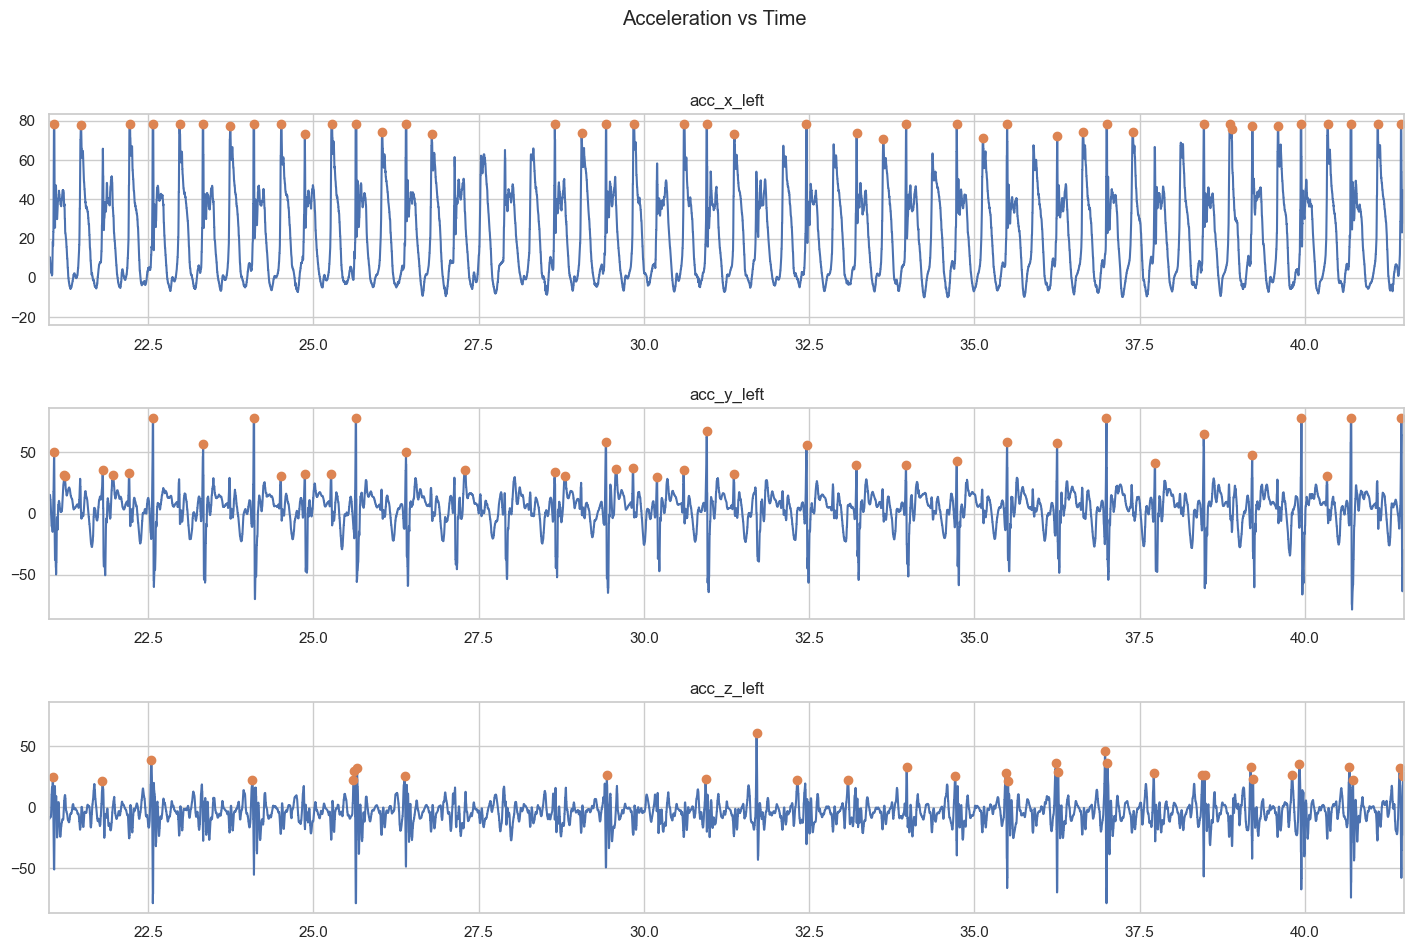

In [27]:
# plot acc_x_left, acc_y_left, acc_z_left of df_004_jog with height1=70, height2=30, height3=20
plot_acc_vs_time_peaks(df_004_jog, 70, 30, 20)

* peaks in the acceleration in x direction occur when the left foot is on the ground 
* and the peaks in the acceleration in y and z directions occur when the left foot is in the air 
* and the person is moving forward because the person is jogging
* the peaks in the acceleration in y and z directions are smaller than the peaks in the acceleration in x direction
* because the person is not pushing off the ground to move forward when the left foot is in the air

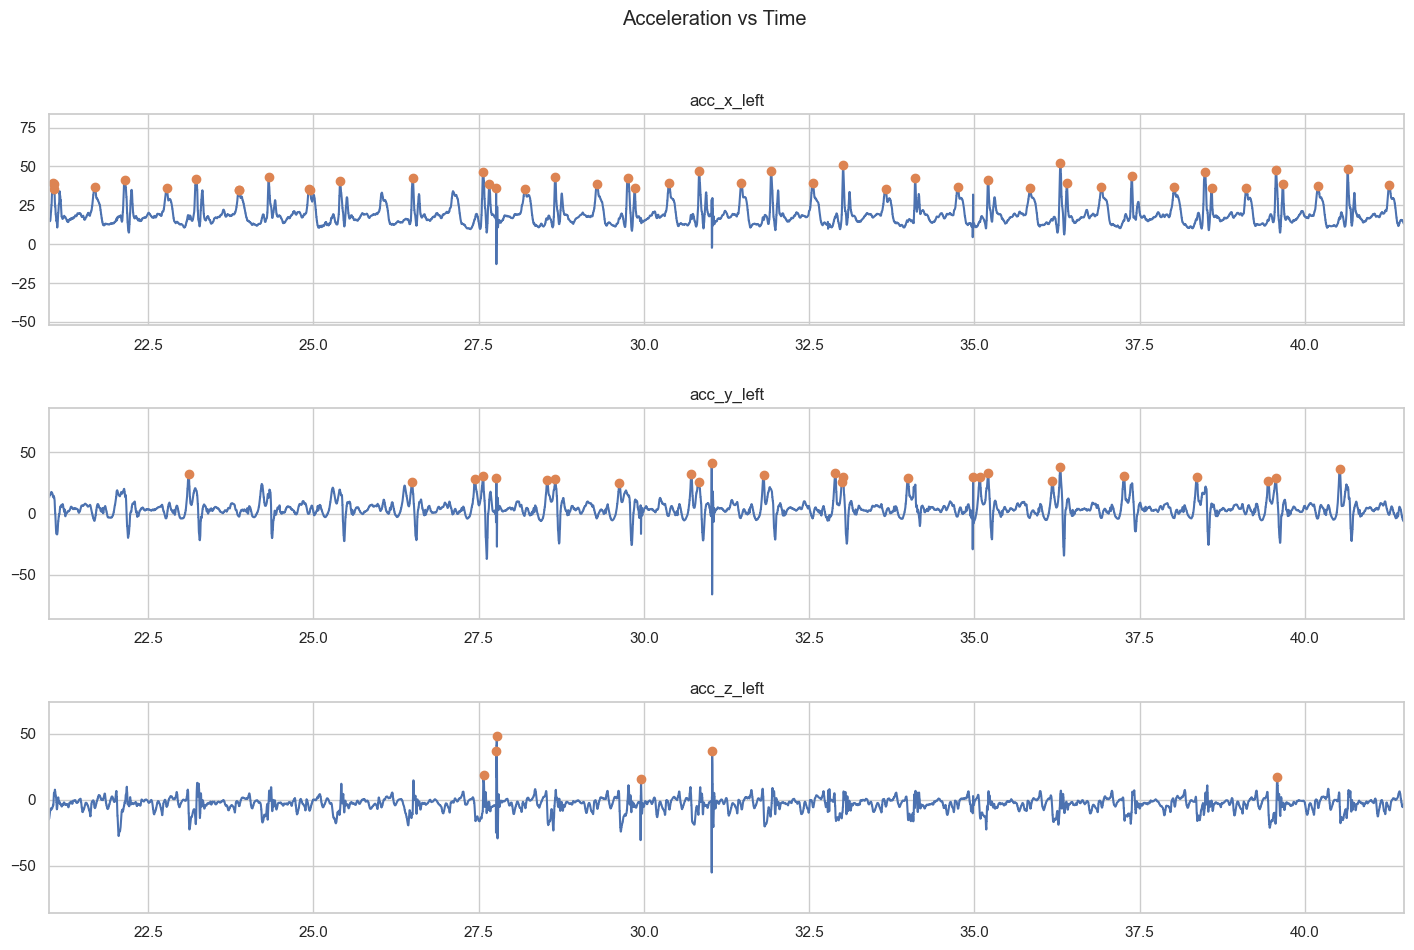

In [28]:
# plot acc_x_left, acc_y_left, acc_z_left of df_009_walk with height1=35, height2=25, height3=15
plot_acc_vs_time_peaks(df_009_walk, 35, 25, 15)

* for walking the peaks and valleys of acc_x_left, acc_y_left and acc_z_left are not as clear as for jogging
* for walking the peaks of acc_x_left means left foot is in the air and valleys of acc_x_left means left foot is on the ground
* for walking the peaks of acc_y_left means left foot is on the ground and valleys of acc_y_left means left foot is in the air
* for walking the peaks of acc_z_left means left foot is in the air and valleys of acc_z_left means left foot is on the ground
* valleys of acc_x_left and acc_z_left are not as clear as peaks of acc_x_left and acc_z_left
* peaks of acc_y_left are not as clear as valleys of acc_y_left

In [29]:
# put everything above into a function
def plot_acc_vs_time_valleys(df,height1, height2, height3):
    fig, axes = plt.subplots(3, 1, figsize=(15,10))
    fig.suptitle('Acceleration vs Time')
    fig.tight_layout(pad=3.0)
    # set limits on x-axis 
    axes[0].set_xlim(21, 41.5)
    axes[0].plot(df['time'], df['acc_x_left'])
    # calculate the valley values of acc_x_left and plot them on the graph
    valley_indices, _ = find_peaks(-df['acc_x_left'], height=height1)
    axes[0].plot(df['time'][valley_indices], df['acc_x_left'][valley_indices], "o")
    axes[0].set_title('acc_x_left')

    axes[1].set_xlim(21, 41.5)
    axes[1].plot(df['time'], df['acc_y_left'])
    # calculate the valley values of acc_y_left and plot them on the graph
    valley_indices, _ = find_peaks(-df['acc_y_left'], height=height2)
    axes[1].plot(df['time'][valley_indices], df['acc_y_left'][valley_indices], "o")
    axes[1].set_title('acc_y_left')

    axes[2].set_xlim(21, 41.5)
    axes[2].plot(df['time'], df['acc_z_left'])
    # calculate the valley values of acc_z_left and plot them on the graph
    valley_indices, _ = find_peaks(-df['acc_z_left'], height=height3)
    axes[2].plot(df['time'][valley_indices], df['acc_z_left'][valley_indices], "o")
    axes[2].set_title('acc_z_left')

    plt.show()

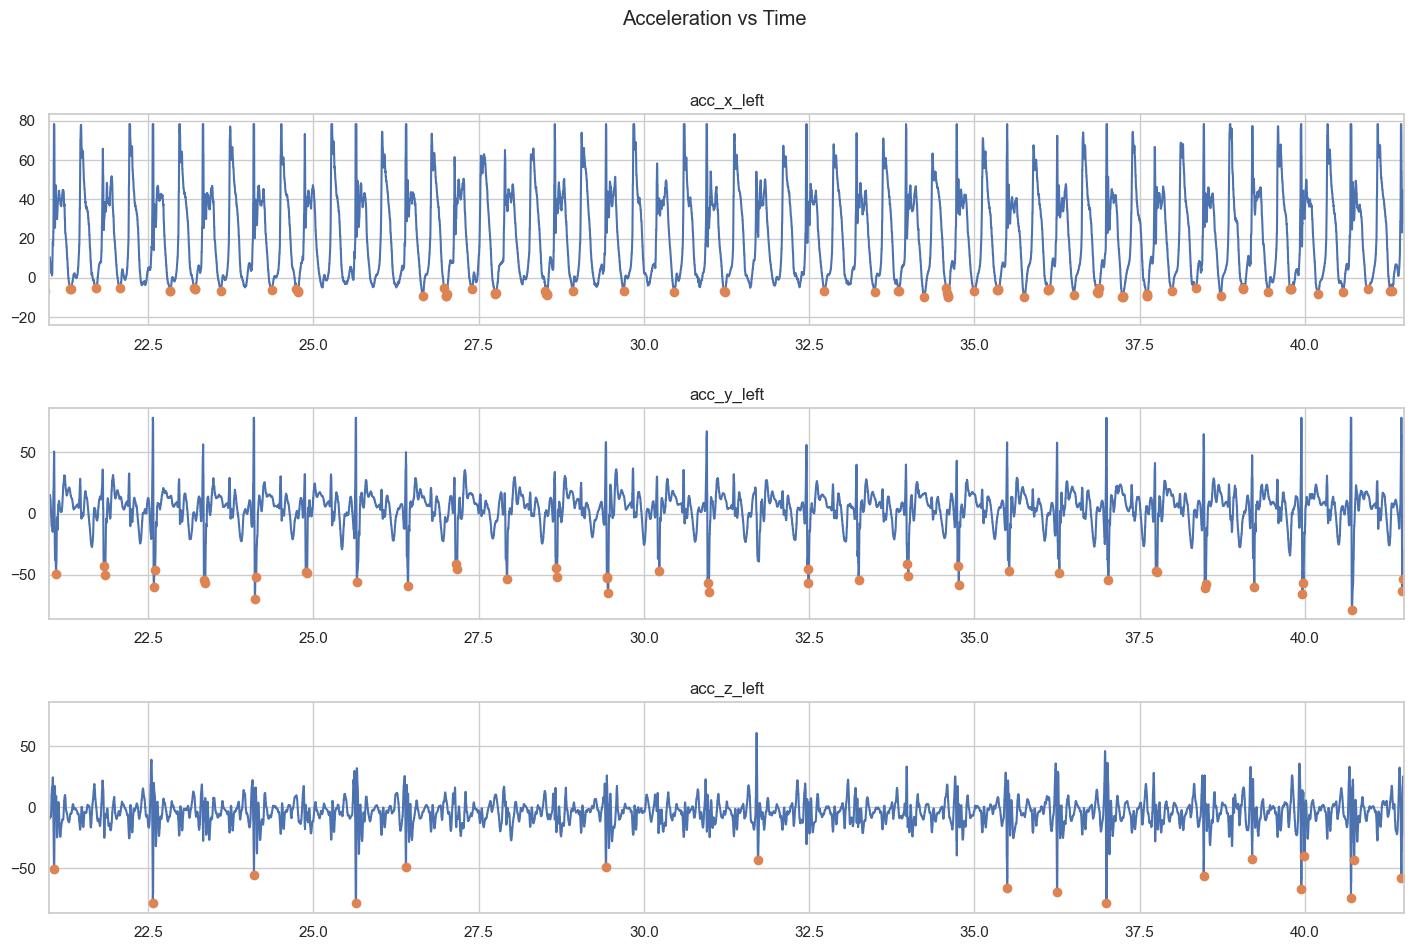

In [30]:
# plot the valley values of acc_x_left, acc_y_left, acc_z_left of df_004_jog on top of each other
plot_acc_vs_time_valleys(df_004_jog, 5, 40, 40)

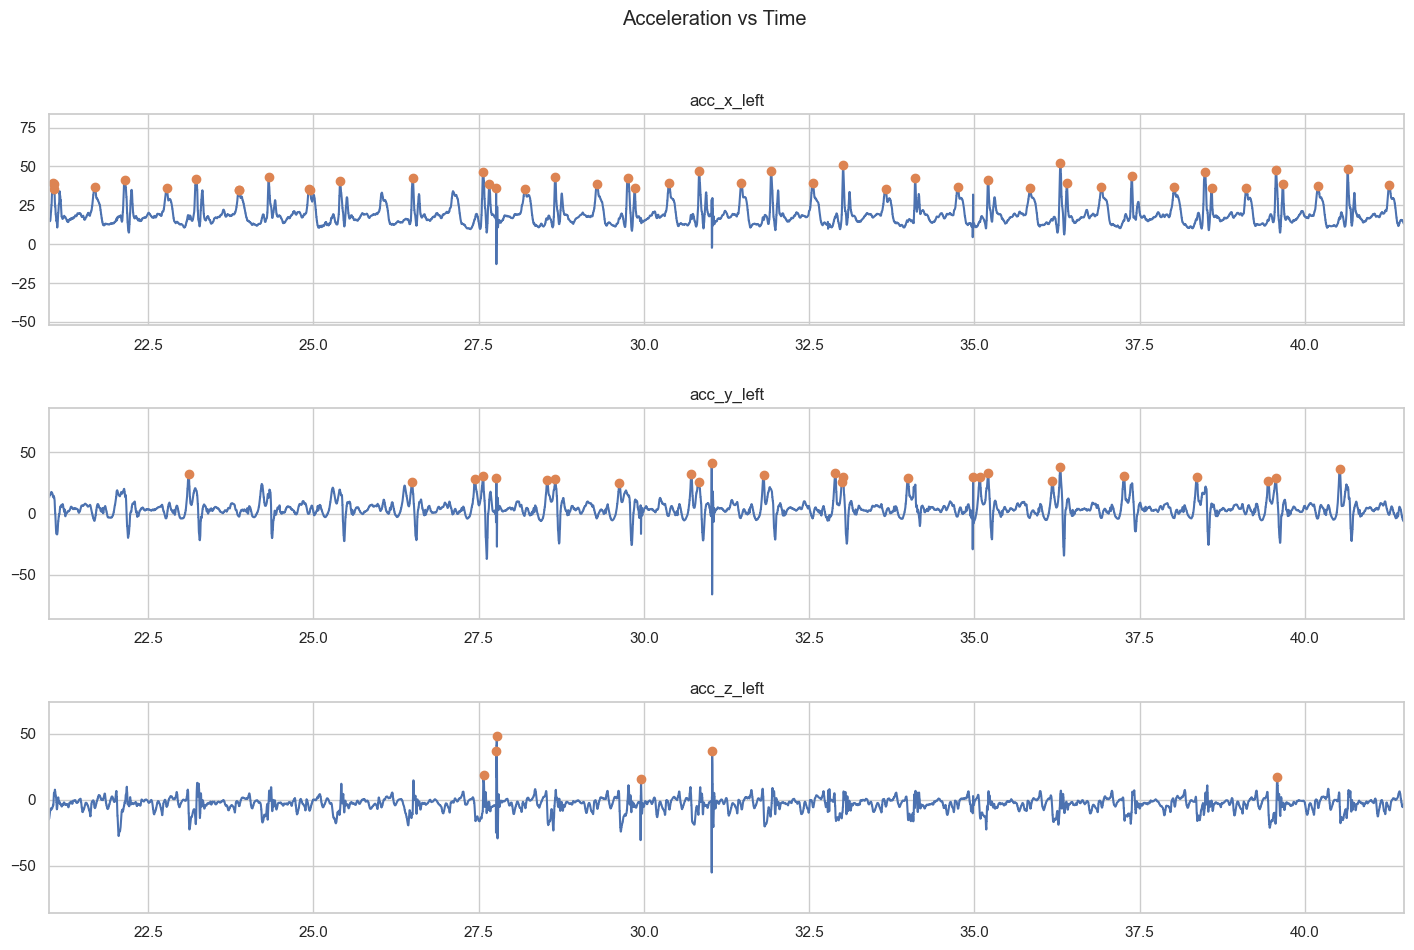

In [31]:
# plot the valley values of acc_x_left, acc_y_left, acc_z_left of df_009_walk on top of each other
plot_acc_vs_time_peaks(df_009_walk, 35, 25, 15)

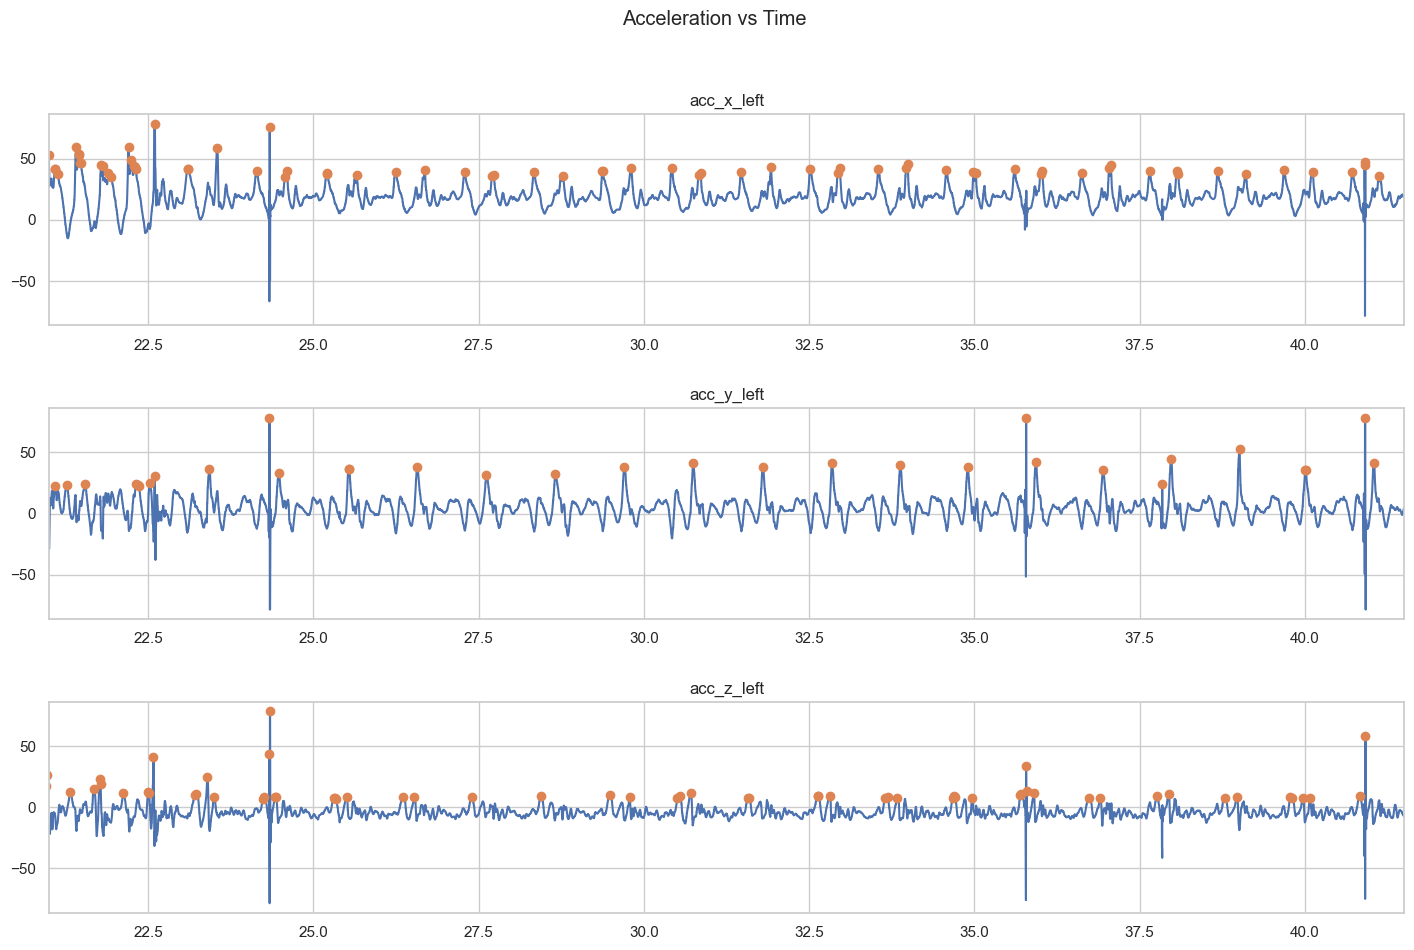

In [32]:
# plot the peak values of acc_x_left, acc_y_left, acc_z_left of df_011_var on top of each other
plot_acc_vs_time_peaks(df_011_var, 35, 20, 7)

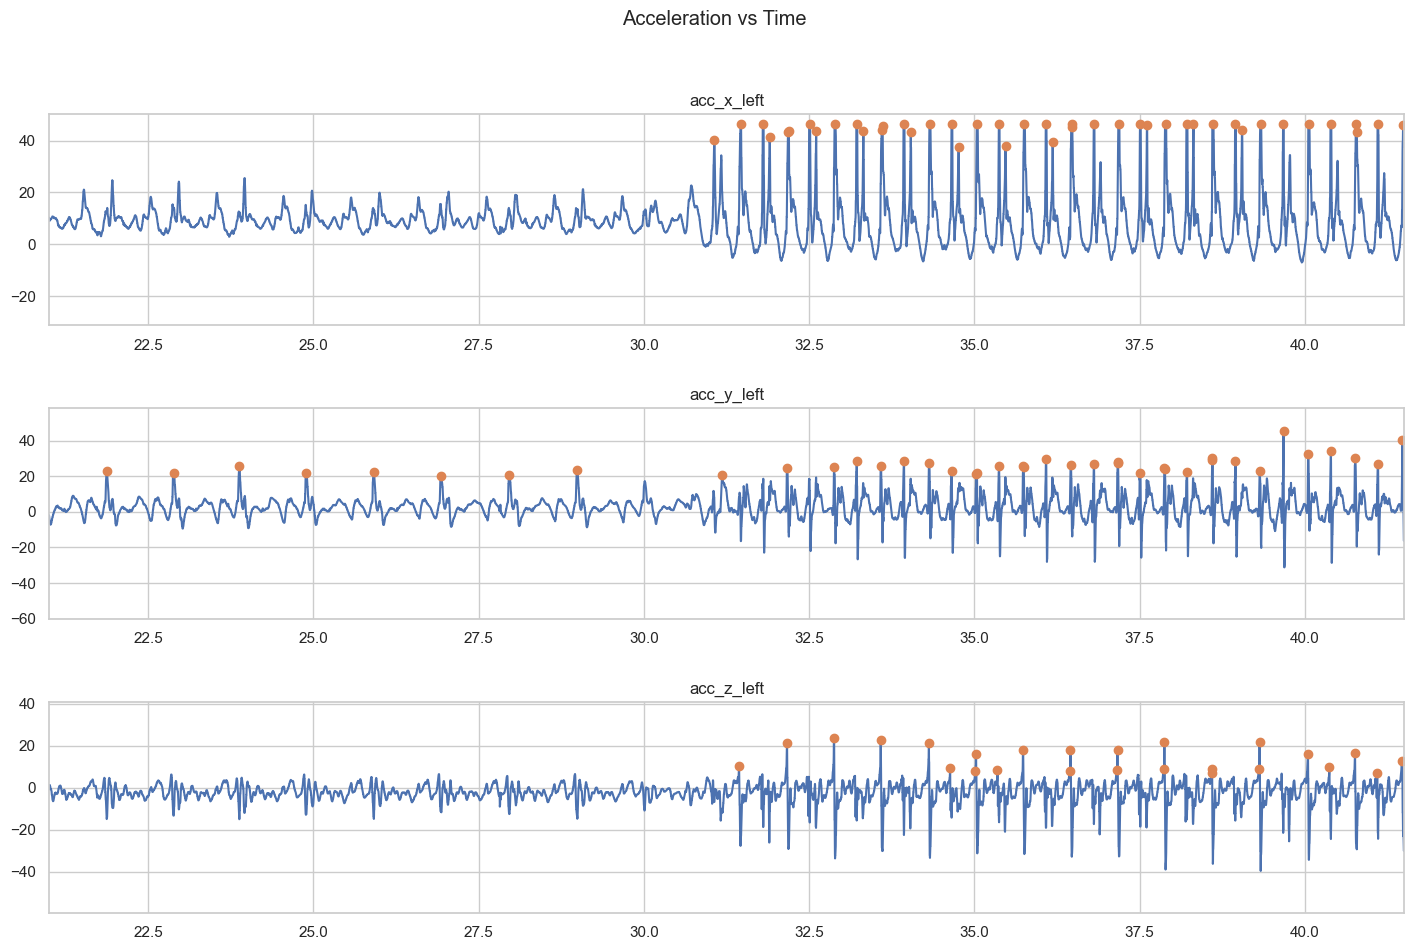

In [33]:
# plot the valley values of acc_x_left, acc_y_left, acc_z_left of df_014_var on top of each other
plot_acc_vs_time_peaks(df_014_var, 35, 20, 7)

In [34]:
# function to plot correlation heatmap of dataframe 
import matplotlib.pyplot as plt
# autocorrelation plot of a time series 
from pandas.plotting import autocorrelation_plot
# lag plot of a time series
from pandas.plotting import lag_plot
def plot_auto_corr_lag_plot(df):
    fig, axes = plt.subplots(2, 3, figsize=(10,5))
    # use dataframe as title of figure
     

    fig.suptitle('Auto-correlation and Lag plot of acc_x_left, acc_y_left, acc_z_left columns')
    fig.tight_layout(pad=3.0)

    axes[0,0].set_xlim(0,10)
    autocorrelation_plot(df['acc_x_left'], ax=axes[0,0])
    lag_plot(df['acc_x_left'], ax=axes[1,0])
    axes[0,0].set_title('acc_x_left')
    axes[1,0].set_title('acc_x_left')

    axes[0,1].set_xlim(0,10)
    autocorrelation_plot(df['acc_y_left'], ax=axes[0,1])
    lag_plot(df['acc_y_left'], ax=axes[1,1])
    axes[0,1].set_title('acc_y_left')
    axes[1,1].set_title('acc_y_left')

    axes[0,2].set_xlim(0,10)
    autocorrelation_plot(df['acc_z_left'], ax=axes[0,2])
    lag_plot(df['acc_z_left'], ax=axes[1,2])
    axes[0,2].set_title('acc_z_left')
    axes[1,2].set_title('acc_z_left')

    plt.show()

    fig, axes = plt.subplots(2, 3, figsize=(10,5))
    fig.suptitle('Auto-correlation and Lag plot of acc_x_right, acc_y_right, acc_z_right columns')
    fig.tight_layout(pad=3.0)

    axes[0,0].set_xlim(0,10)
    autocorrelation_plot(df['acc_x_right'], ax=axes[0,0])
    lag_plot(df['acc_x_right'], ax=axes[1,0])
    axes[0,0].set_title('acc_x_right')
    axes[1,0].set_title('acc_x_right')
    
    axes[0,1].set_xlim(0,10)
    autocorrelation_plot(df['acc_y_right'], ax=axes[0,1])
    lag_plot(df['acc_y_right'], ax=axes[1,1])
    axes[0,1].set_title('acc_y_right')
    axes[1,1].set_title('acc_y_right')

    axes[0,2].set_xlim(0,10)
    autocorrelation_plot(df['acc_z_right'], ax=axes[0,2])
    lag_plot(df['acc_z_right'], ax=axes[1,2])
    axes[0,2].set_title('acc_z_right')
    axes[1,2].set_title('acc_z_right')

    plt.show()

df_004_jog


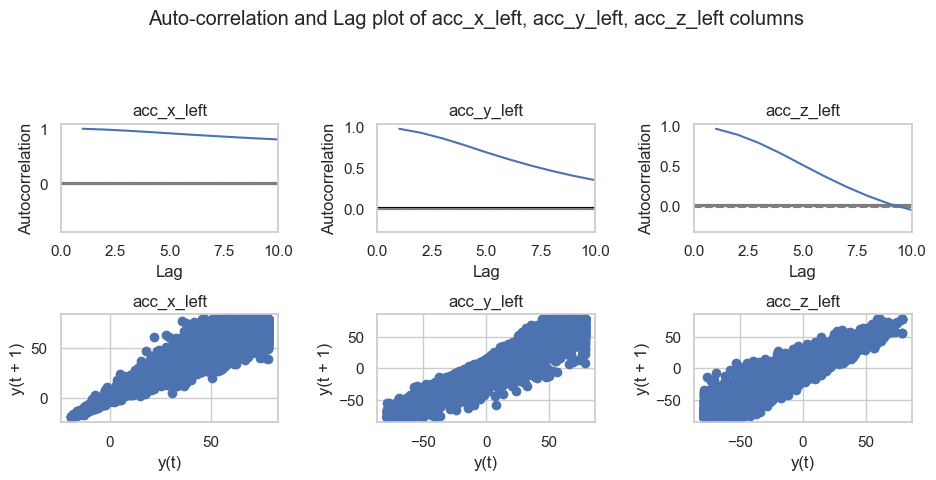

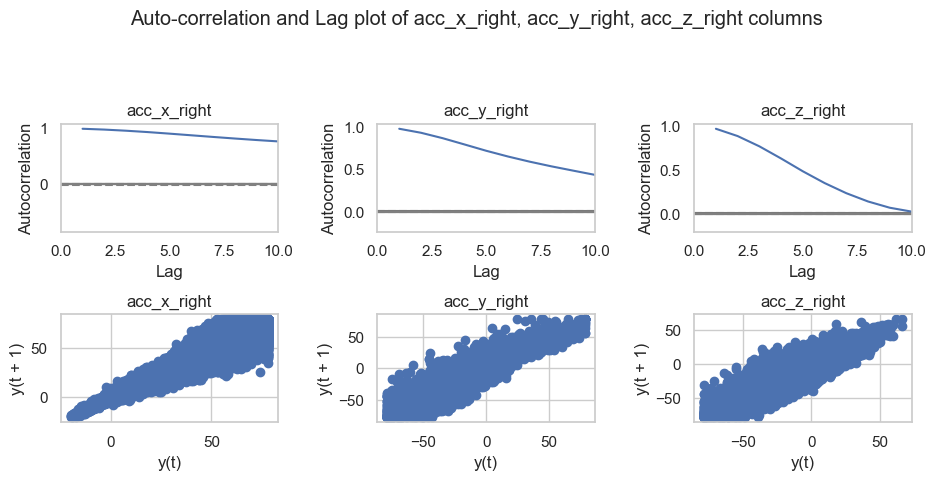

df_009_walk


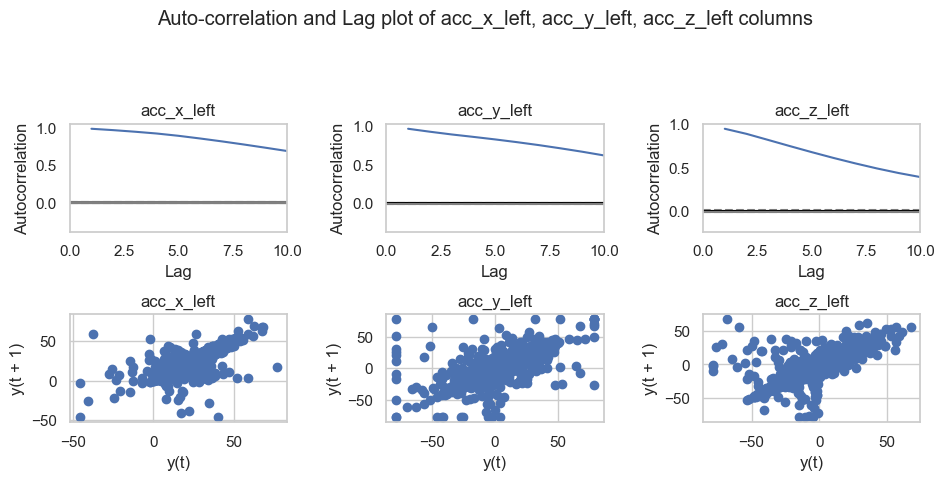

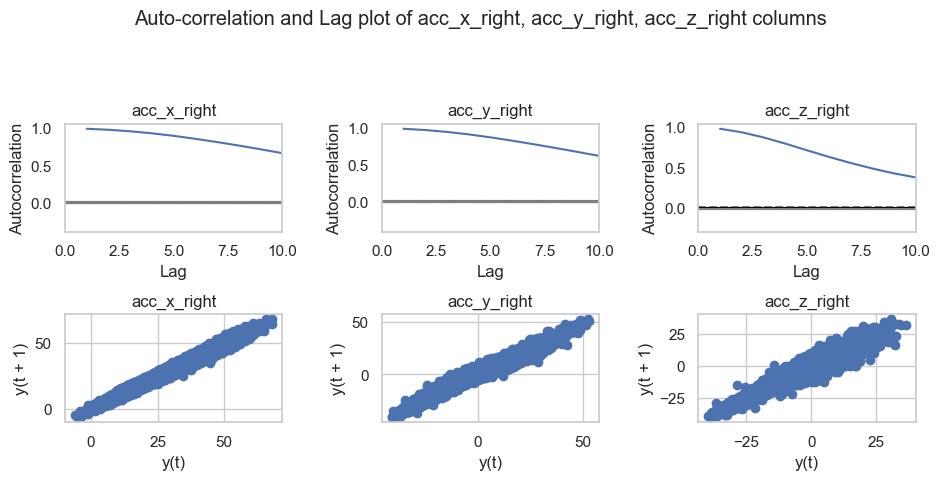

df_011_var


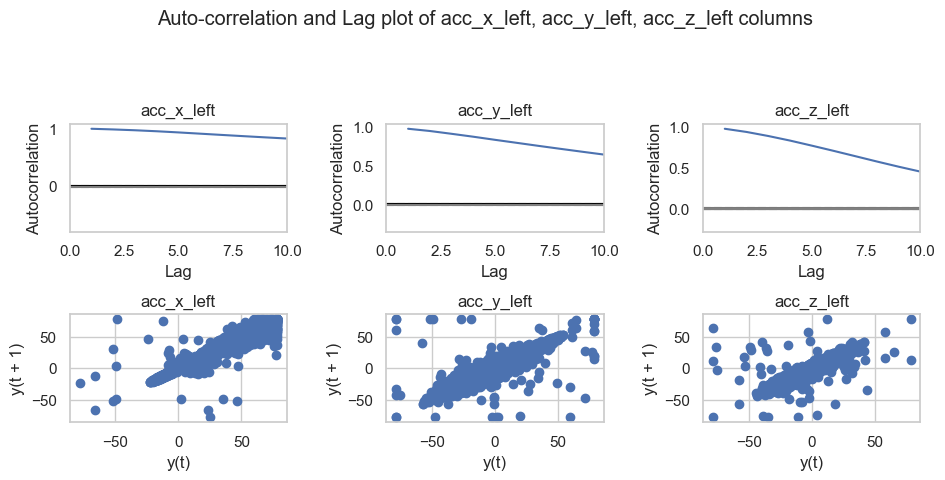

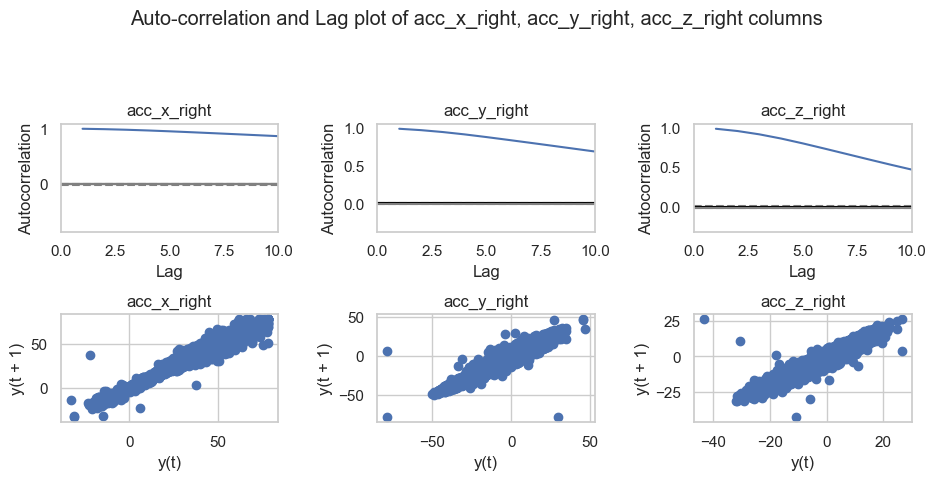

df_014_var


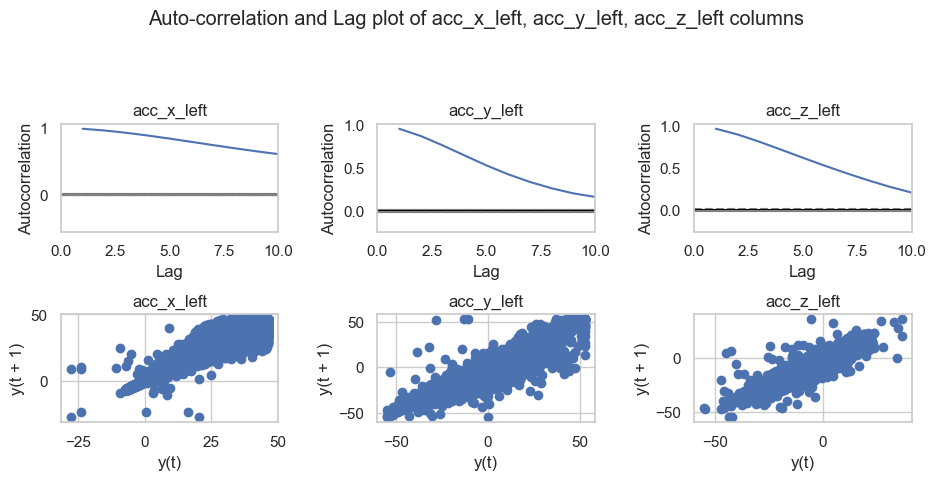

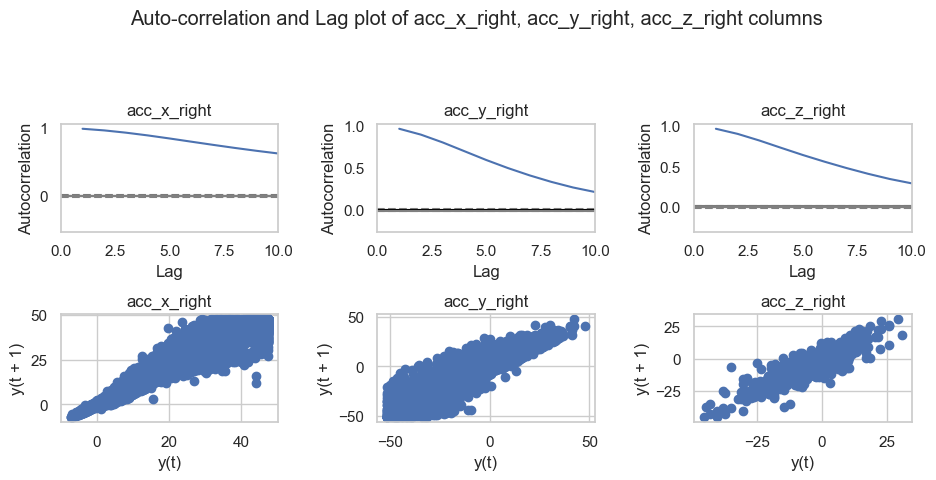

df_017_jog


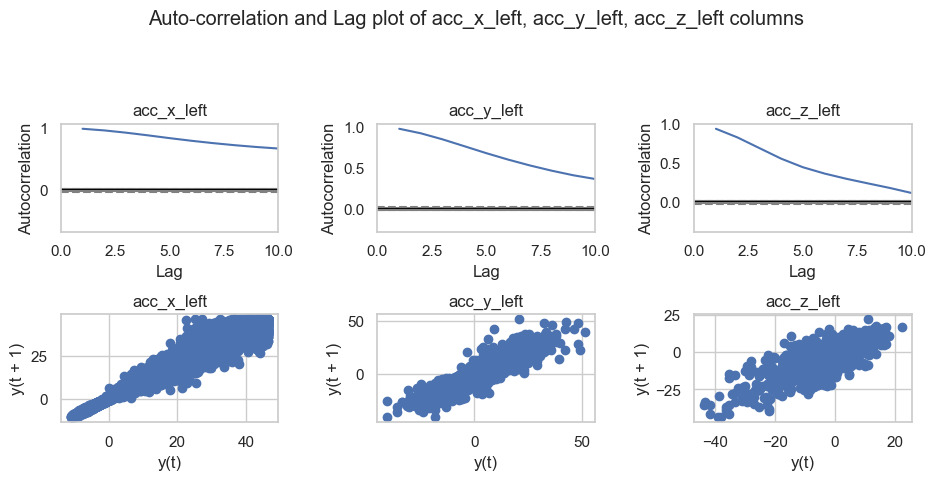

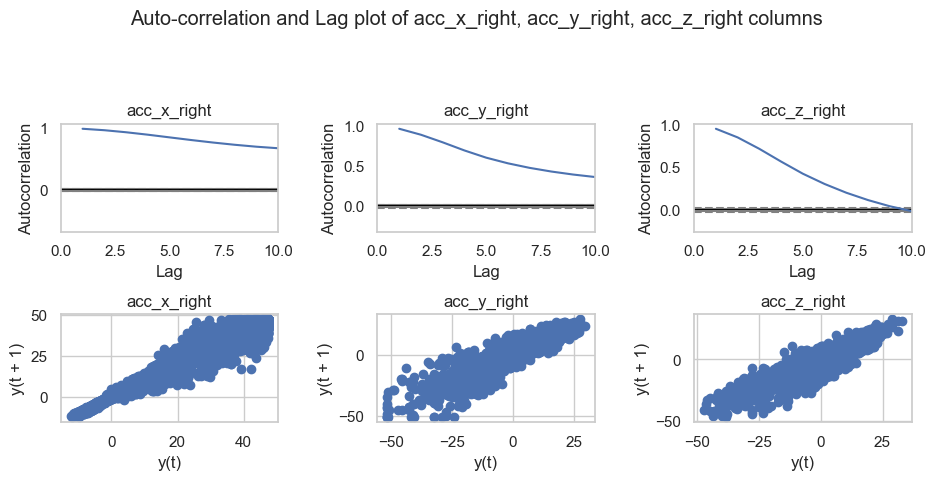

df_017_walk


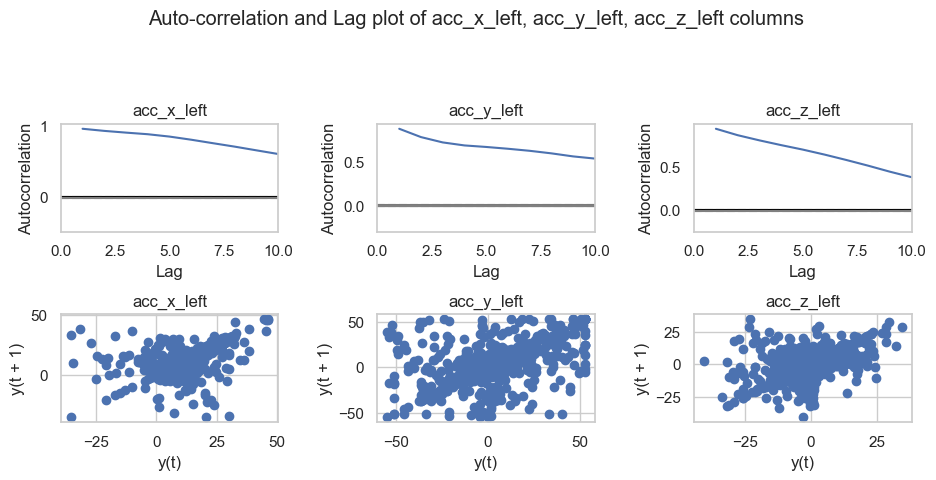

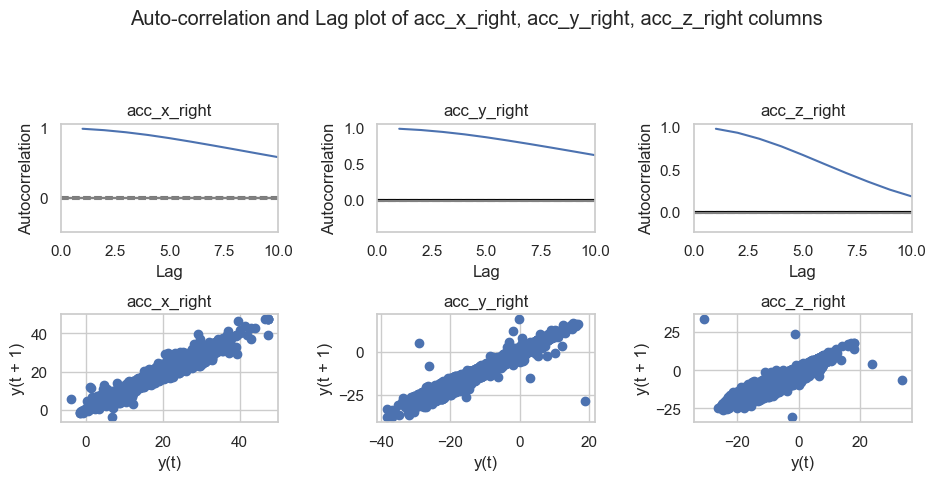

In [35]:
# take each dataset and plot auto-correlation and lag plot for all the datasets in the same row using subplots and set lag value between 0 and 10 for auto-correlation plot
title_names = ['df_004_jog', 'df_009_walk', 'df_011_var', 'df_014_var', 'df_017_jog', 'df_017_walk']
datasets = [df_004_jog, df_009_walk, df_011_var, df_014_var, df_017_jog, df_017_walk]
for i in range(len(datasets)):
    print(title_names[i])
    plot_auto_corr_lag_plot(datasets[i])

*   For autocorrelation plots, one can see (in most cases) a high autocorrelation at lag 1 that slowly decreases. The decreasing autocorrelation is generally linear with some noise. Such an autocorrelation plot siginifies the presence of strong autocorrelation in the data.

*   For the lag plots, see the tight clustering of the data points along the diagonal for almost all the activities. Such a behavior is a signature of a process with strong positive autocorrelation. These processes exhibit highly non-random behavior. In other words, there is a strong association between an observation and a succeeding observation. 

*   In conclusion, both the lag plots and the autocorrelation plots show strong positive autocorrelation that suggests that the data come from an underlying autoregressive process

## 2. Data ingestion 

In [36]:
# import libraries
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

# function to check for and remove duplicate rows
def check_duplicates(df):
    print("Shape of dataframe before dropping duplicates:")
    print(df.shape)
    df.drop_duplicates(inplace=True)
    print("Shape of dataframe after dropping duplicates:")
    print(df.shape)
    return df

# function to make dataset
def make_augmented_dataset(filenames):
    # read each file in the list of filenames into a dataframe
    df_list = [pd.read_csv(filename, header=0, index_col=0) for filename in filenames]
    for df in df_list:
        df['time'] = df.index * 0.002
    # check for and remove duplicate rows
    for df in df_list:
        df = check_duplicates(df)
    # concatenate all dataframes in the list
    dataset = pd.concat(df_list, axis=0, ignore_index=True)
    dataset['target'] = dataset['left_phase']
    dataset = dataset.drop(columns=['left_phase'])
    dataset = dataset.reset_index(drop=True)
    batch_input_data = dataset.drop(columns=['target'])
    labels = dataset['target']
    batch_labels = labels
    X = batch_input_data
    y = batch_labels
    # split the data into train, validation, and test sets 
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=random_state, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=random_state, stratify= y_rem)
    # scale the numeric features and one hot encode the categorical features
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    numeric_transformer = StandardScaler()
    categorical_features = X_train.select_dtypes(include=['object']).columns
    categorical_transformer = OneHotEncoder()
    preprocessor = make_column_transformer((numeric_transformer, numeric_features), (categorical_transformer, categorical_features))
    # fit the preprocessor on the training set and transform the training set 
    preprocessor.fit(X_train)
    X_train = preprocessor.transform(X_train)
    # transform the validation set and test set
    X_val = preprocessor.transform(X_val)
    X_test = preprocessor.transform(X_test)
    # reshape the data
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    # one hot encode the labels
    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)
    # return (X_train, y_train), (X_val, y_val), (X_test, y_test) as tuple
    train_dataset = (X_train, y_train)
    val_dataset = (X_val, y_val)
    test_dataset = (X_test, y_test)
    return train_dataset, val_dataset, test_dataset

In [37]:
# get the train, validation, and test datasets
train_dataset, val_dataset, test_dataset = make_augmented_dataset(filenames)

Shape of dataframe before dropping duplicates:
(100000, 14)
Shape of dataframe after dropping duplicates:
(100000, 14)
Shape of dataframe before dropping duplicates:
(100000, 14)
Shape of dataframe after dropping duplicates:
(100000, 14)
Shape of dataframe before dropping duplicates:
(100000, 14)
Shape of dataframe after dropping duplicates:
(100000, 14)
Shape of dataframe before dropping duplicates:
(74407, 14)
Shape of dataframe after dropping duplicates:
(74407, 14)
Shape of dataframe before dropping duplicates:
(19007, 14)
Shape of dataframe after dropping duplicates:
(19007, 14)
Shape of dataframe before dropping duplicates:
(100000, 14)
Shape of dataframe after dropping duplicates:
(100000, 14)


In [38]:
# print the shapes of the train, validation, and test datasets
print("Shape of train dataset:")
print(train_dataset[0].shape)
print("Shape of validation dataset:")
print(val_dataset[0].shape)
print("Shape of test dataset:")
print(test_dataset[0].shape)

# print the shapes of the train, validation, and test labels
print("Shape of train labels:")
print(train_dataset[1].shape)
print("Shape of validation labels:")
print(val_dataset[1].shape)
print("Shape of test labels:")
print(test_dataset[1].shape)

Shape of train dataset:
(394731, 1, 13)
Shape of validation dataset:
(49341, 1, 13)
Shape of test dataset:
(49342, 1, 13)
Shape of train labels:
(394731, 12)
Shape of validation labels:
(49341, 12)
Shape of test labels:
(49342, 12)


## 3. Model building 

In [39]:
# create a neural network model for multiclass classification with 12 classes and early stopping callback 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
def create_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(1, 13), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(12, activation='softmax'))
    callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## 4. Validation

In [40]:
def train_and_validate():
    # run the model on the train dataset and validate on the validation dataset
    model = create_model()

    history = model.fit(train_dataset[0], train_dataset[1], epochs=100, validation_data=val_dataset, callbacks=callbacks)

    # print training and validation accuracy and loss
    print("Training accuracy: ", history.history['accuracy'][-1])
    print("Validation accuracy: ", history.history['val_accuracy'][-1])
    print("Training loss: ", history.history['loss'][-1])
    print("Validation loss: ", history.history['val_loss'][-1])

    model.summary()

    # calculate the predictions on the test dataset
    predictions = model.predict(test_dataset[0])

    # calculate the accuracy on the test dataset
    from sklearn.metrics import accuracy_score
    accuracy_score(np.argmax(test_dataset[1], axis=1), np.argmax(predictions, axis=1))

    # print training, validation, and test accuracy
    print("Training accuracy: ", history.history['accuracy'][-1])
    print("Validation accuracy: ", history.history['val_accuracy'][-1])
    print("Test accuracy: ", accuracy_score(np.argmax(test_dataset[1], axis=1), np.argmax(predictions, axis=1)))

    # print confusion matrix as percentage %
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(np.argmax(test_dataset[1], axis=1), np.argmax(predictions, axis=1))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0
    # show as heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f', square=True)
    # label the axes
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    return model, history, predictions, cm

Epoch 1/100
12336/12336 [==============================] - 33s 3ms/step - loss: 0.6096 - accuracy: 0.7827 - val_loss: 0.3295 - val_accuracy: 0.8816
Epoch 2/100
12336/12336 [==============================] - 34s 3ms/step - loss: 0.4311 - accuracy: 0.8422 - val_loss: 0.2956 - val_accuracy: 0.8898
Epoch 3/100
12336/12336 [==============================] - 29s 2ms/step - loss: 0.4039 - accuracy: 0.8517 - val_loss: 0.2838 - val_accuracy: 0.8914
Epoch 4/100
12336/12336 [==============================] - 30s 2ms/step - loss: 0.3920 - accuracy: 0.8554 - val_loss: 0.2814 - val_accuracy: 0.8929
Epoch 5/100
12336/12336 [==============================] - 31s 2ms/step - loss: 0.3846 - accuracy: 0.8578 - val_loss: 0.2729 - val_accuracy: 0.8954
Epoch 6/100
12336/12336 [==============================] - 44s 4ms/step - loss: 0.3790 - accuracy: 0.8600 - val_loss: 0.2647 - val_accuracy: 0.8979
Epoch 7/100
12336/12336 [==============================] - 35s 3ms/step - loss: 0.3761 - accuracy: 0.8604 - val_

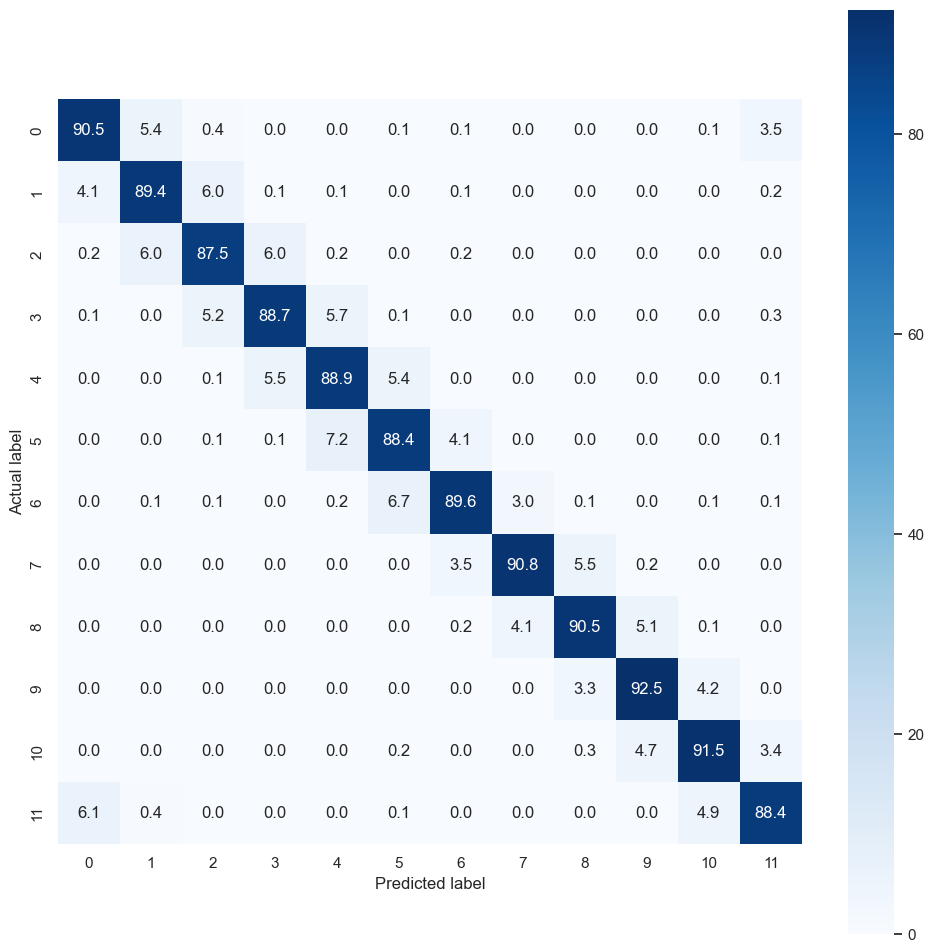

In [41]:
# train and validate the model
model, history, predictions, cm = train_and_validate()

In [42]:
# save the model 
model.save('model_multiclass.h5')

In [43]:
# load the model and make predictions on the test dataset
from tensorflow.keras.models import load_model
model = load_model('model_multiclass.h5')
predictions = model.predict(test_dataset[0])

# print the accuracy on the test dataset
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(test_dataset[1], axis=1), np.argmax(predictions, axis=1))

1542/1542 [==============================] - 3s 2ms/step


0.8976936484131166

# Conclusions

* Training accuracy:  0.866, means the model is 86.6% accurate on the training dataset
* Validation accuracy:  0.898, means the model is 89.8% accurate on the validation dataset
* Test accuracy:  0.899, means the model is 89.9% accurate on the test dataset
* The model is overfitting because the training accuracy is greater than the validation accuracy
* The model is predicting the gait phases well because the test accuracy is 89.9% and the confusion matrix shows that the model is predicting the gait phases well

* The confusion matrix shows the percentage of correctly classified samples in each class.
* The diagonal elements represent the percentage of correctly classified samples for each class.
* The off-diagonal elements are misclassified samples.
* The confusion matrix shows that the model is able to classify the samples with high accuracy.